# Summary

Dans ce notebook, nous allons faire l'analyseexploiratoire des données du projet restaurant revenue prediction.
Ce projet s'inscrit dans le cadre du cours de mlOPS. C'est un projet initié par TFI qui est le propriétaire de beaucoup de chaines de restauration. En effet,

##  Installation des librairies Python

In [ ]:
!python3 -m pip install --upgrade pip

In [ ]:
!pip3 install dill matplotlib missingno pandas seaborn optuna plotly pendulum loguru yellowbrick ydata_profiling

# Librairies

In [105]:
# reload modules before executing user code.
#%reload_ext autoreload
#%autoreload 2

import sys
from pathlib import Path
import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import pendulum
import seaborn as sns
from loguru import logger
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             max_error,
                            )
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot


sys.path.append(str(Path.cwd().parent))
from settings.params import (DATA_DIR_INPUT,
                             DATA_DIR_OUTPUT,
                             MODEL_PARAMS,
                             REPORT_DIR,
                             TIMEZONE,
                            )
from src.make_dataset import load_data


set_config(display="diagram", print_changed_only=False)
pd.set_option("display.max_columns", None)

/home/dosecurity/Desktop/notebooks/notebookEnv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Settings

In [3]:
# time in UTC
log_fmt = ("<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | "
           "<cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
          )
log_config = {
    "handlers": [
        {"sink": sys.stderr, "format": log_fmt},
    ],
}
logger.configure(**log_config)


[1]

In [4]:
EXECUTION_DATE = pendulum.now(tz=TIMEZONE)

logger.info(f"Execution date: {EXECUTION_DATE}")

logger.info(f"\nData input directory : {DATA_DIR_INPUT}\nData output directory: {DATA_DIR_OUTPUT}")


# model parameters
FEATURES = MODEL_PARAMS.get("FEATURES")
TARGET_NAME = MODEL_PARAMS["TARGET"]

2023-08-21 23:44:54.168 | INFO     | __main__:<module>:3 - Execution date: 2023-08-21T23:44:54.168097+00:00
2023-08-21 23:44:54.180 | INFO     | __main__:<module>:5 - 
Data input directory : /Users/baldita/Desktop/Courses/DIC3/mlops/project/mlops-project-dic3/data/input
Data output directory: /Users/baldita/Desktop/Courses/DIC3/mlops/project/mlops-project-dic3/data/output


# data_train Collection

## **NB** 
Notre dataset est deja subdivise en `train` et `test`. Ce qui fait que l'exploration, le preprocessing se fera conjointement sur les deux datasets pour garder une coherence dans la typologie des donnees des deux datasets

In [5]:
data_train = pd.read_csv(str(DATA_DIR_INPUT) + "/train.csv.zip")
data_test = pd.read_csv(str(DATA_DIR_INPUT) + "/test.csv.zip")

In [6]:
data_train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0


In [7]:
data_test.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,5,4,5,5,5,3,4.0,0,0,0,2,0,5,5,3,1,4,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,2,5,3,4,4,2,4,5.0,0,0,0,0,0,5,5,3,2,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,2,5,4,4,5,4,5,5.0,0,0,0,0,0,5,5,5,5,5,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,3,5,4,5,4,3,4,5.0,0,0,0,0,4,4,4,3,2,2,0,0,0.0,0.0,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,2,5,4,5,4,3,5,4.0,0,0,0,0,0,1,5,3,1,1,0,0,0.0,0.0,5.0,3.0,0,0,0,0,0,0,0,0


In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          137 non-null    int64  
 1   Open Date   137 non-null    object 
 2   City        137 non-null    object 
 3   City Group  137 non-null    object 
 4   Type        137 non-null    object 
 5   P1          137 non-null    int64  
 6   P2          137 non-null    float64
 7   P3          137 non-null    float64
 8   P4          137 non-null    float64
 9   P5          137 non-null    int64  
 10  P6          137 non-null    int64  
 11  P7          137 non-null    int64  
 12  P8          137 non-null    int64  
 13  P9          137 non-null    int64  
 14  P10         137 non-null    int64  
 15  P11         137 non-null    int64  
 16  P12         137 non-null    int64  
 17  P13         137 non-null    float64
 18  P14         137 non-null    int64  
 19  P15         137 non-null    i

In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          100000 non-null  int64  
 1   Open Date   100000 non-null  object 
 2   City        100000 non-null  object 
 3   City Group  100000 non-null  object 
 4   Type        100000 non-null  object 
 5   P1          100000 non-null  int64  
 6   P2          100000 non-null  float64
 7   P3          100000 non-null  float64
 8   P4          100000 non-null  float64
 9   P5          100000 non-null  int64  
 10  P6          100000 non-null  int64  
 11  P7          100000 non-null  int64  
 12  P8          100000 non-null  int64  
 13  P9          100000 non-null  int64  
 14  P10         100000 non-null  int64  
 15  P11         100000 non-null  int64  
 16  P12         100000 non-null  int64  
 17  P13         100000 non-null  float64
 18  P14         100000 non-null  int64  
 19  P15

In [10]:
data_train.columns

Index(['Id', 'Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37', 'revenue'],
      dtype='object')

In [16]:
data_test.columns

Index(['Id', 'Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37'],
      dtype='object')

In [17]:
print(data_train.shape)
print(data_test.shape)

(137, 43)
(100000, 42)


Nous nous rendons compte que les deux datasets ont des tailles differentes. 
- 137 restaurants pour le `train` pour 43 colonnes
- 100000 restaurants pour le `test` pour 42 colonnes
Ainsi nous nous rendons compte que `train` a beaucoup mois d'enregistrements que le `test`. De plus le `test` ne comporte pas la variable cible,donc ce sont des donnees non labelisees.

Ces deux remarques nous indiquent que nous devons:
- Eviter le "overfitting" lors du training
- Trouver une solution pour tester nos modeles malgre la contrainte du nombre restraint dans le training set 

### Variables quantitatives

In [18]:
data_train.describe(include="int")

,Id,P1,P5,P6,P7,P8,P9,P10,P11,P12,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P30,P31,P32,P33,P34,P35,P36,P37
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,68.000000,4.014599,2.007299,3.357664,5.423358,5.153285,5.445255,5.489051,3.262774,5.299270,1.416058,1.386861,1.941606,1.036496,1.941606,4.905109,4.547445,2.270073,2.226277,3.423358,1.372263,1.211679,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788
std,39.692569,2.910391,1.209620,2.134235,2.296809,1.858567,1.834793,1.847561,1.910767,1.941668,2.729583,2.398677,3.505807,2.030679,3.300549,5.604467,3.708041,2.052630,1.230690,4.559609,2.304112,2.133179,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,2.000000,1.000000,2.000000,5.000000,4.000000,4.000000,5.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68.000000,3.000000,2.000000,3.000000,5.000000,5.000000,5.000000,5.000000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,4.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102.000000,4.000000,2.000000,4.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,2.000000,2.000000,3.000000,1.000000,4.000000,5.000000,5.000000,3.000000,3.000000,5.000000,2.000000,2.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000
max,136.000000,12.000000,8.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,15.000000,10.000000,15.000000,15.000000,12.000000,25.000000,15.000000,15.000000,5.000000,25.000000,10.000000,10.000000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000


In [19]:
data_test.describe(include="int")

,Id,P1,P5,P6,P7,P8,P9,P10,P11,P12,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P30,P31,P32,P33,P34,P35,P36,P37
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,49999.500000,4.088030,1.989590,2.881900,5.30051,4.93100,5.251380,5.458970,3.311720,5.061440,1.280090,1.305530,1.747070,1.156880,1.708470,5.191120,4.57086,2.542380,2.430380,3.63998,1.234450,1.244110,2.083300,1.193330,1.942640,0.987430,2.108670,1.832830,1.968890,0.973500
std,28867.657797,2.812963,1.065314,1.531429,2.17858,1.71849,1.702632,1.763601,2.068118,1.765383,2.496782,2.166949,3.172012,2.432646,3.030527,5.785529,3.61243,2.526046,1.363184,4.71916,2.097457,2.084731,4.309479,2.307944,3.971298,1.534808,4.685414,3.228769,3.805773,1.677267
min,0.000000,1.000000,1.000000,1.000000,1.00000,1.00000,4.000000,4.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24999.750000,2.000000,1.000000,2.000000,5.00000,4.00000,4.000000,5.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.00000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49999.500000,3.000000,2.000000,2.000000,5.00000,5.00000,5.000000,5.000000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,4.00000,2.000000,2.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,74999.250000,4.000000,2.000000,4.000000,5.00000,5.00000,5.000000,5.000000,4.000000,5.000000,2.000000,2.000000,3.000000,2.000000,4.000000,5.000000,5.00000,3.000000,3.000000,4.00000,2.000000,2.000000,3.000000,1.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000
max,99999.000000,15.000000,6.000000,10.000000,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,15.000000,10.000000,15.000000,15.000000,15.000000,25.000000,15.00000,15.000000,5.000000,25.00000,10.000000,10.000000,25.000000,15.000000,25.000000,6.000000,30.000000,15.000000,20.000000,8.000000


### Variables catégorielles

In [20]:
data_train.describe(include="object")

,Open Date,City,City Group,Type
count,137,137,137,137
unique,134,34,2,3
top,02/23/2010,İstanbul,Big Cities,FC
freq,2,50,78,76


In [21]:
data_test.describe(include="object")

,Open Date,City,City Group,Type
count,100000,100000,100000,100000
unique,310,57,2,4
top,07/10/2013,İstanbul,Other,FC
freq,645,34087,50728,57019


### features data_train

In [10]:
#data_features = data_train[MODEL_PARAMS['FEATURES']]

In [11]:
#data_features

### Verification de valeurs manquantes

In [24]:
data_train.isnull().sum()

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
dtype: int64

In [23]:
data_test.isnull().sum()

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
dtype: int64

Nous nous rendons compte qu'il n'y a aucune valeur manquante dans les deux datasets

# EDA: Exploratory data_train Analysis
### Partie exploratoire des donnees

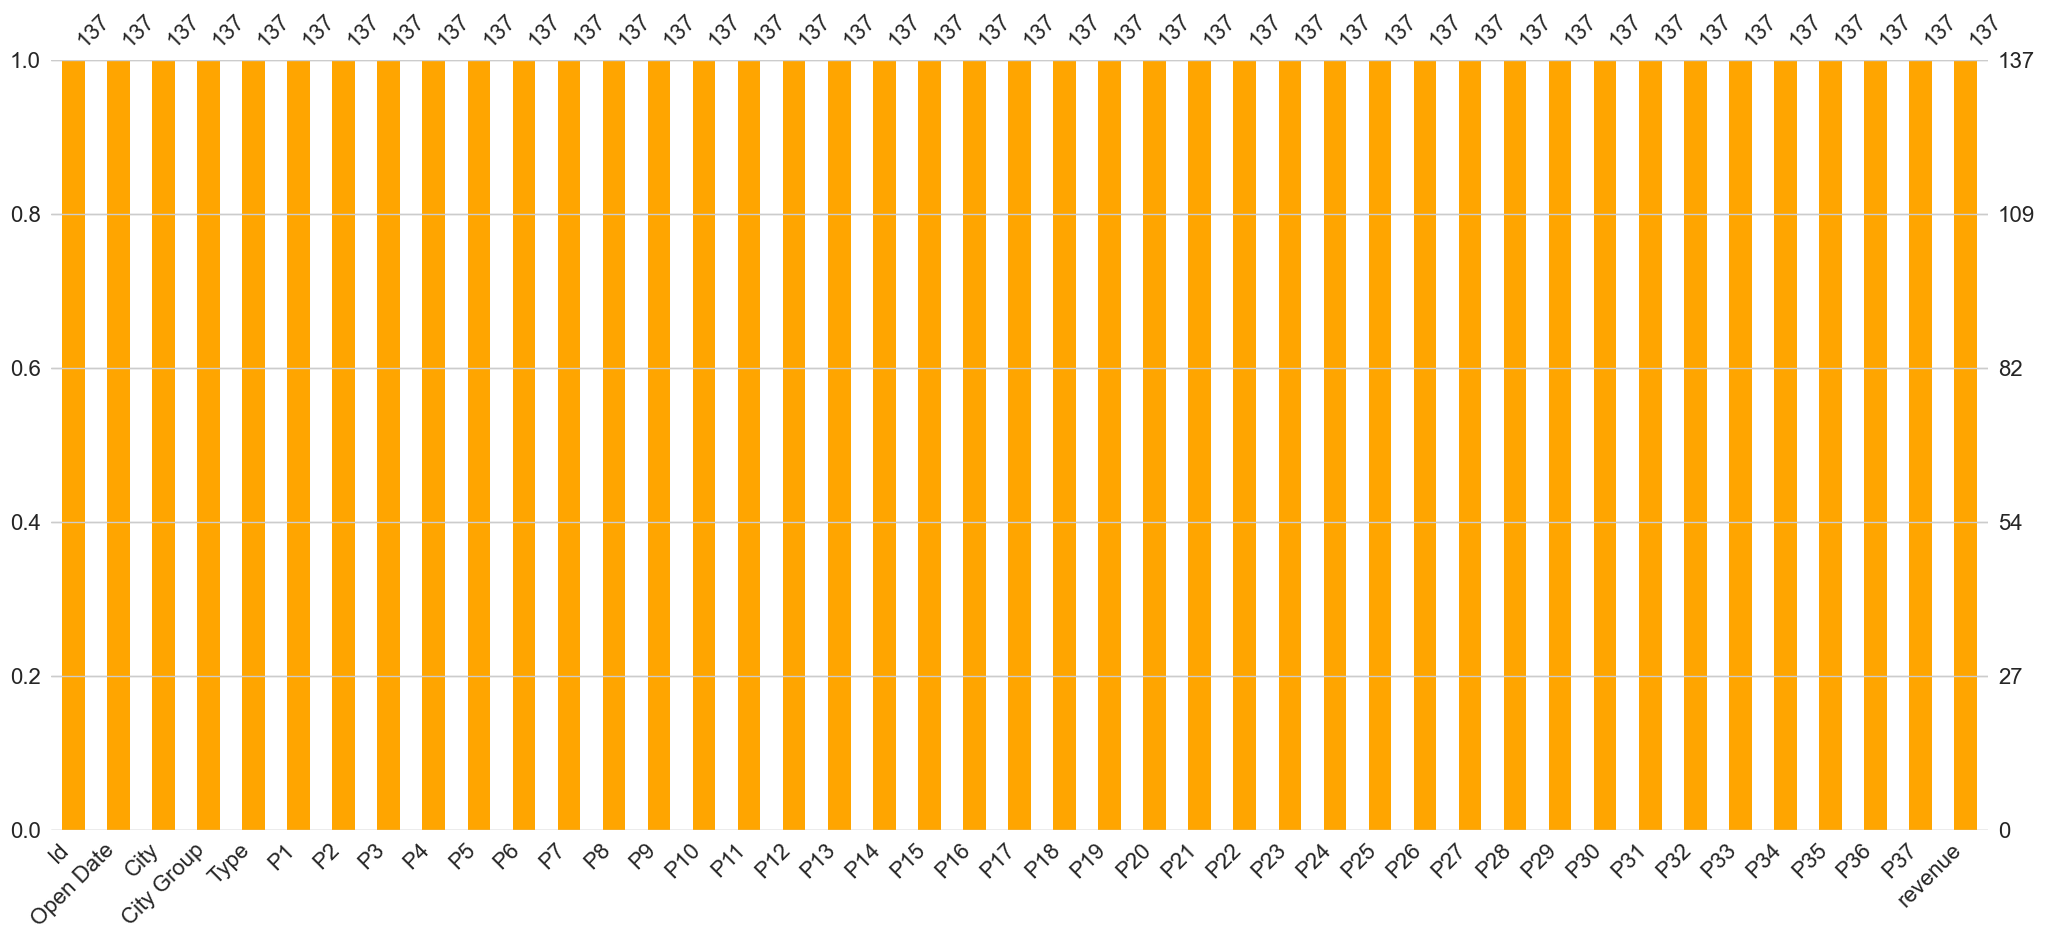

In [39]:
msno.bar(data_train,
         filter="top",
         color="orange"
        );

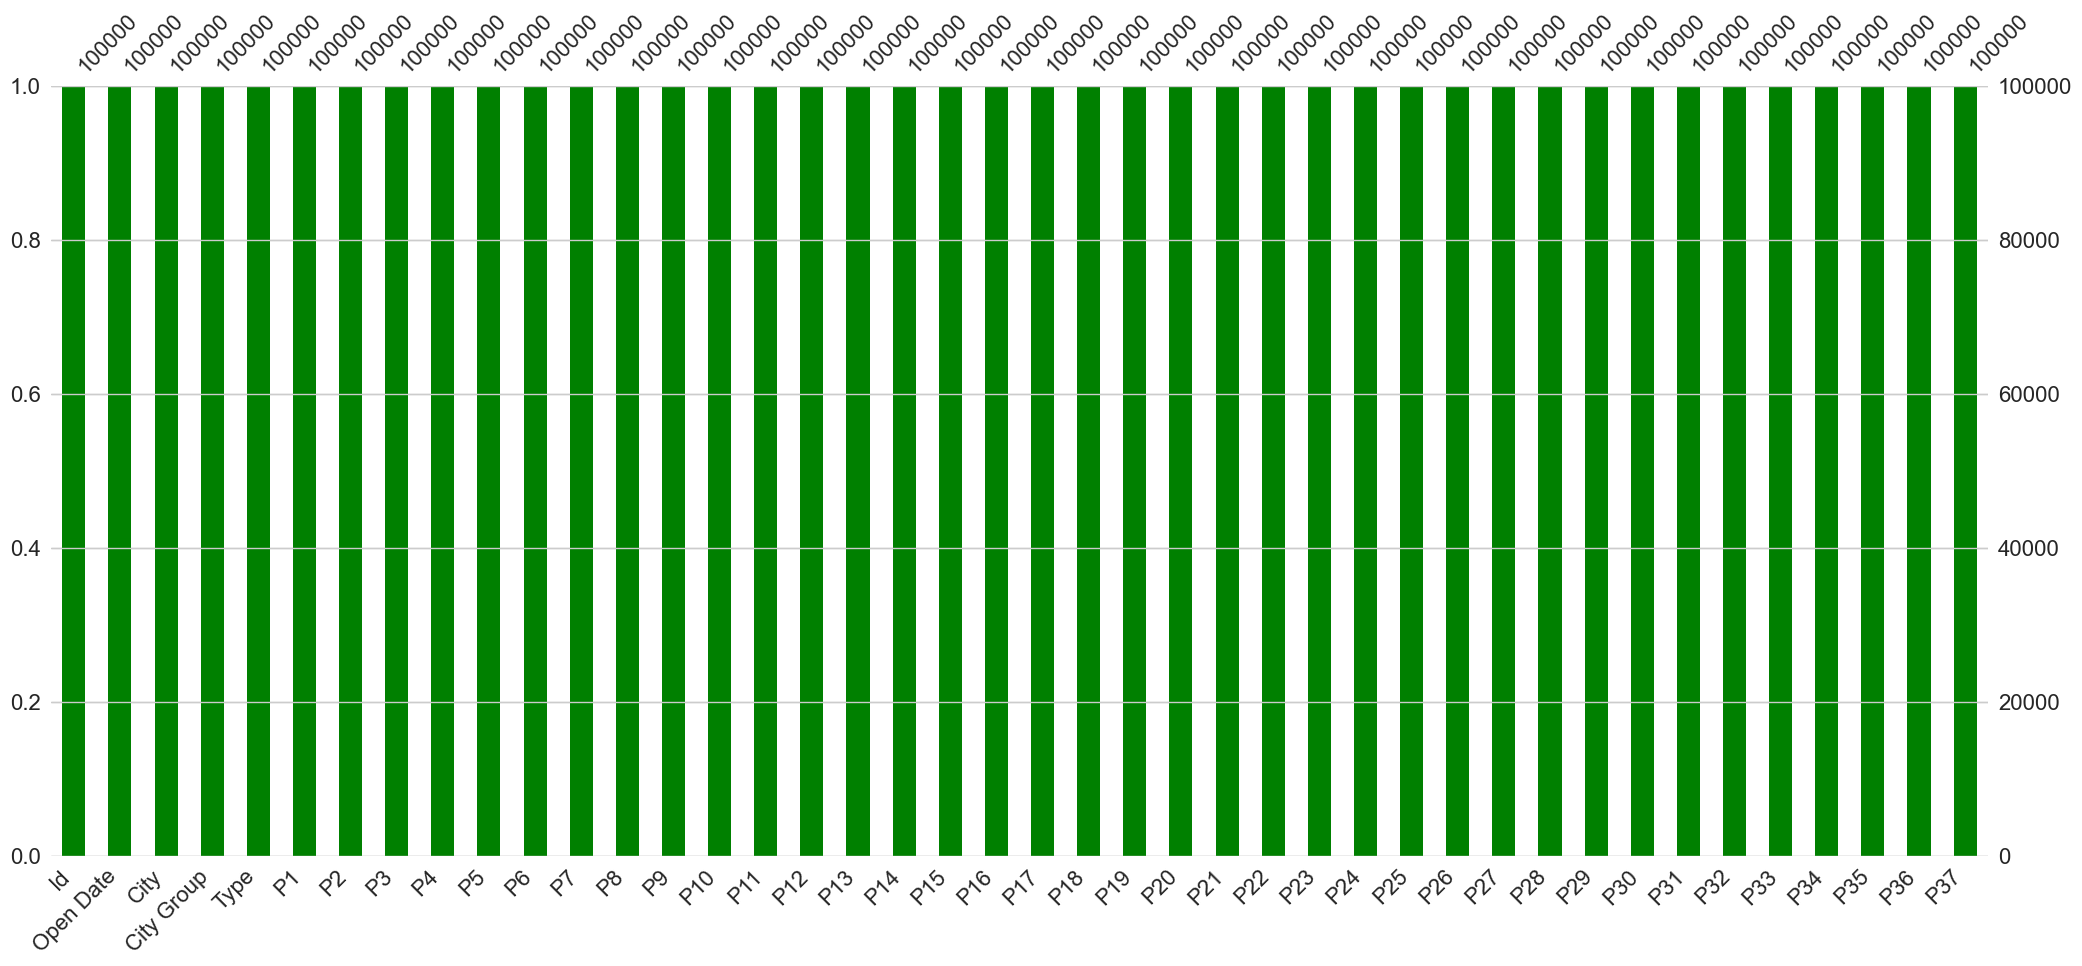

In [37]:
msno.bar(data_test,
         filter="top",
         color="green"
        );

Ce diagramme vient confirmer, notre conslusion sur le fait qu'il n'y avait pas de donnees manquantes dans les deux datasets

### Variable cible

##### Description

In [40]:
# Target: stat description
data_train[TARGET_NAME].describe()

count    1.370000e+02
mean     4.453533e+06
std      2.576072e+06
min      1.149870e+06
25%      2.999068e+06
50%      3.939804e+06
75%      5.166635e+06
max      1.969694e+07
Name: revenue, dtype: float64

##### Distribution de la densite

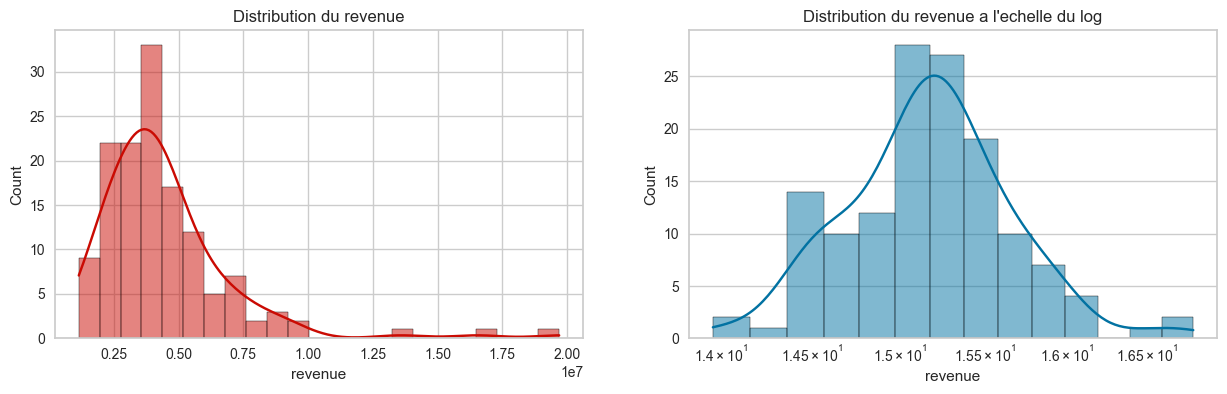

In [41]:
# Target distribution: raw vs log (box-cox transformation)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.histplot(data_train[TARGET_NAME], color='r', kde=True, ax=axes[0])
axes[0].set_title('Distribution du revenue')

sns.histplot(np.log(1+data_train[TARGET_NAME]), color='b', kde=True, ax=axes[1])
axes[1].set_title('Distribution du revenue a l\'echelle du log')
axes[1].set_xscale('log')

Nous voyons que la variable cible est tres assymetrique. Cette assymetrie est due a des valeurs extremes qui indiquent des revenues avec de gros ecarts entre les differents restaurants

###     Exploration des features

Passons a l'exploration des features

- La Variable Type: Cette variable indique le type de restaurant

In [42]:
data_train.Type.describe()

count     137
unique      3
top        FC
freq       76
Name: Type, dtype: object

In [43]:
data_test.Type.describe()

count     100000
unique         4
top           FC
freq       57019
Name: Type, dtype: object

In [17]:
data_train.Type.unique()

array(['IL', 'FC', 'DT'], dtype=object)

In [44]:
data_test.Type.unique()

array(['FC', 'IL', 'DT', 'MB'], dtype=object)

Text(0.5, 1.0, '"Type" dans le Test Set')

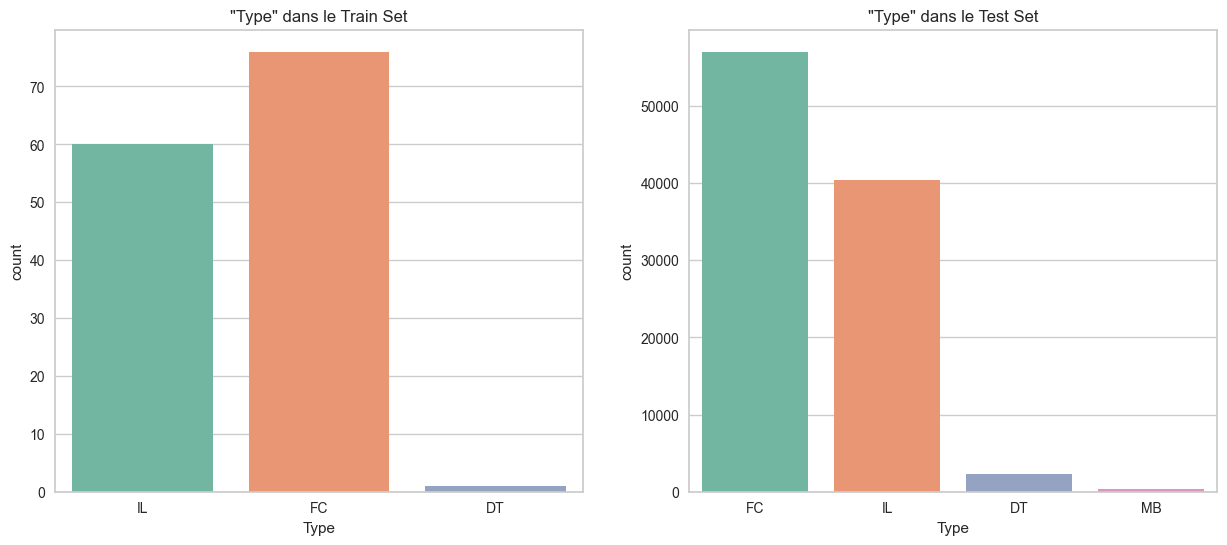

In [47]:
figures, axes = plt.subplots(1,2,figsize=(15,6))

plt.subplot(1,2,1)
sns.countplot(x=data_train.Type, data=data_train, palette="Set2")
plt.title("\"Type\" dans le Train Set")

plt.subplot(1,2,2)
sns.countplot(x=data_test.Type, data=data_test, palette="Set2")
plt.title("\"Type\" dans le Test Set")


Dans le train et le test,le nombre de "DT" (drive-thru) est très faible voir inexistant. "IL" et "FC" sont plus representes, ce qui indique que ces deux types de restaurants semblent etre les plus appréciés. 
"FC" (Food Court) est le type de restaurant le plus apprécié.
Un fait est que le type "MB" qui indique les restaurants mobiles est seulement present dans le `test`. Ainsi, vu qu'il est pas categorise dans le train et qu'il ne comporte qu'une seule ocuurence, elle sera remplacee par la categorie "DT" qui se rapproche le plus de cette categorie.

In [48]:
data_test.Type = data_test.Type.replace("MB","DT")

<Axes: xlabel='Type', ylabel='count'>

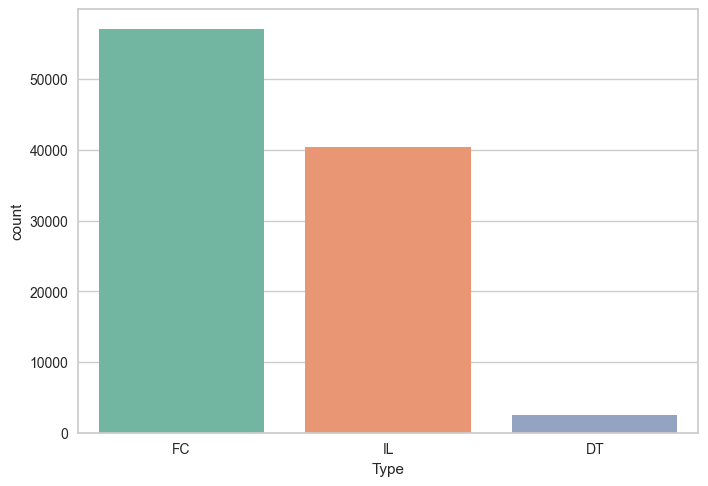

In [49]:
sns.countplot(x=data_test.Type, data=data_test, palette="Set2")

- La Variable City: Cette variable nous donne la ville dans laquelle le restaurant est situe

In [19]:
data_train.City.describe()

count          137
unique          34
top       İstanbul
freq            50
Name: City, dtype: object

In [20]:
data_train.City.unique()

array(['İstanbul', 'Ankara', 'Diyarbakır', 'Tokat', 'Gaziantep',
       'Afyonkarahisar', 'Edirne', 'Kocaeli', 'Bursa', 'İzmir', 'Sakarya',
       'Elazığ', 'Kayseri', 'Eskişehir', 'Şanlıurfa', 'Samsun', 'Adana',
       'Antalya', 'Kastamonu', 'Uşak', 'Muğla', 'Kırklareli', 'Konya',
       'Karabük', 'Tekirdağ', 'Denizli', 'Balıkesir', 'Aydın', 'Amasya',
       'Kütahya', 'Bolu', 'Trabzon', 'Isparta', 'Osmaniye'], dtype=object)

In [50]:
data_test.City.describe()

count       100000
unique          57
top       İstanbul
freq         34087
Name: City, dtype: object

In [52]:
data_test.City.unique()

array(['Niğde', 'Konya', 'Ankara', 'Kocaeli', 'Afyonkarahisar',
       'Eskişehir', 'Rize', 'İstanbul', 'Trabzon', 'Antalya', 'Muğla',
       'Düzce', 'Adana', 'Bursa', 'Aydın', 'Hatay', 'Denizli', 'İzmir',
       'Gaziantep', 'Samsun', 'Erzurum', 'Edirne', 'Balıkesir', 'Mersin',
       'Zonguldak', 'Malatya', 'Çanakkale', 'Kars', 'Bolu', 'Batman',
       'Bilecik', 'Giresun', 'Tekirdağ', 'Sivas', 'Kırıkkale', 'Mardin',
       'Erzincan', 'Manisa', 'Diyarbakır', 'Kahramanmaraş', 'Yalova',
       'Tanımsız', 'Sakarya', 'Kırşehir', 'Aksaray', 'Kayseri',
       'Nevşehir', 'Çorum', 'Ordu', 'Kırklareli', 'Şanlıurfa', 'Artvin',
       'Uşak', 'Kütahya', 'Siirt', 'Çankırı', 'Isparta'], dtype=object)

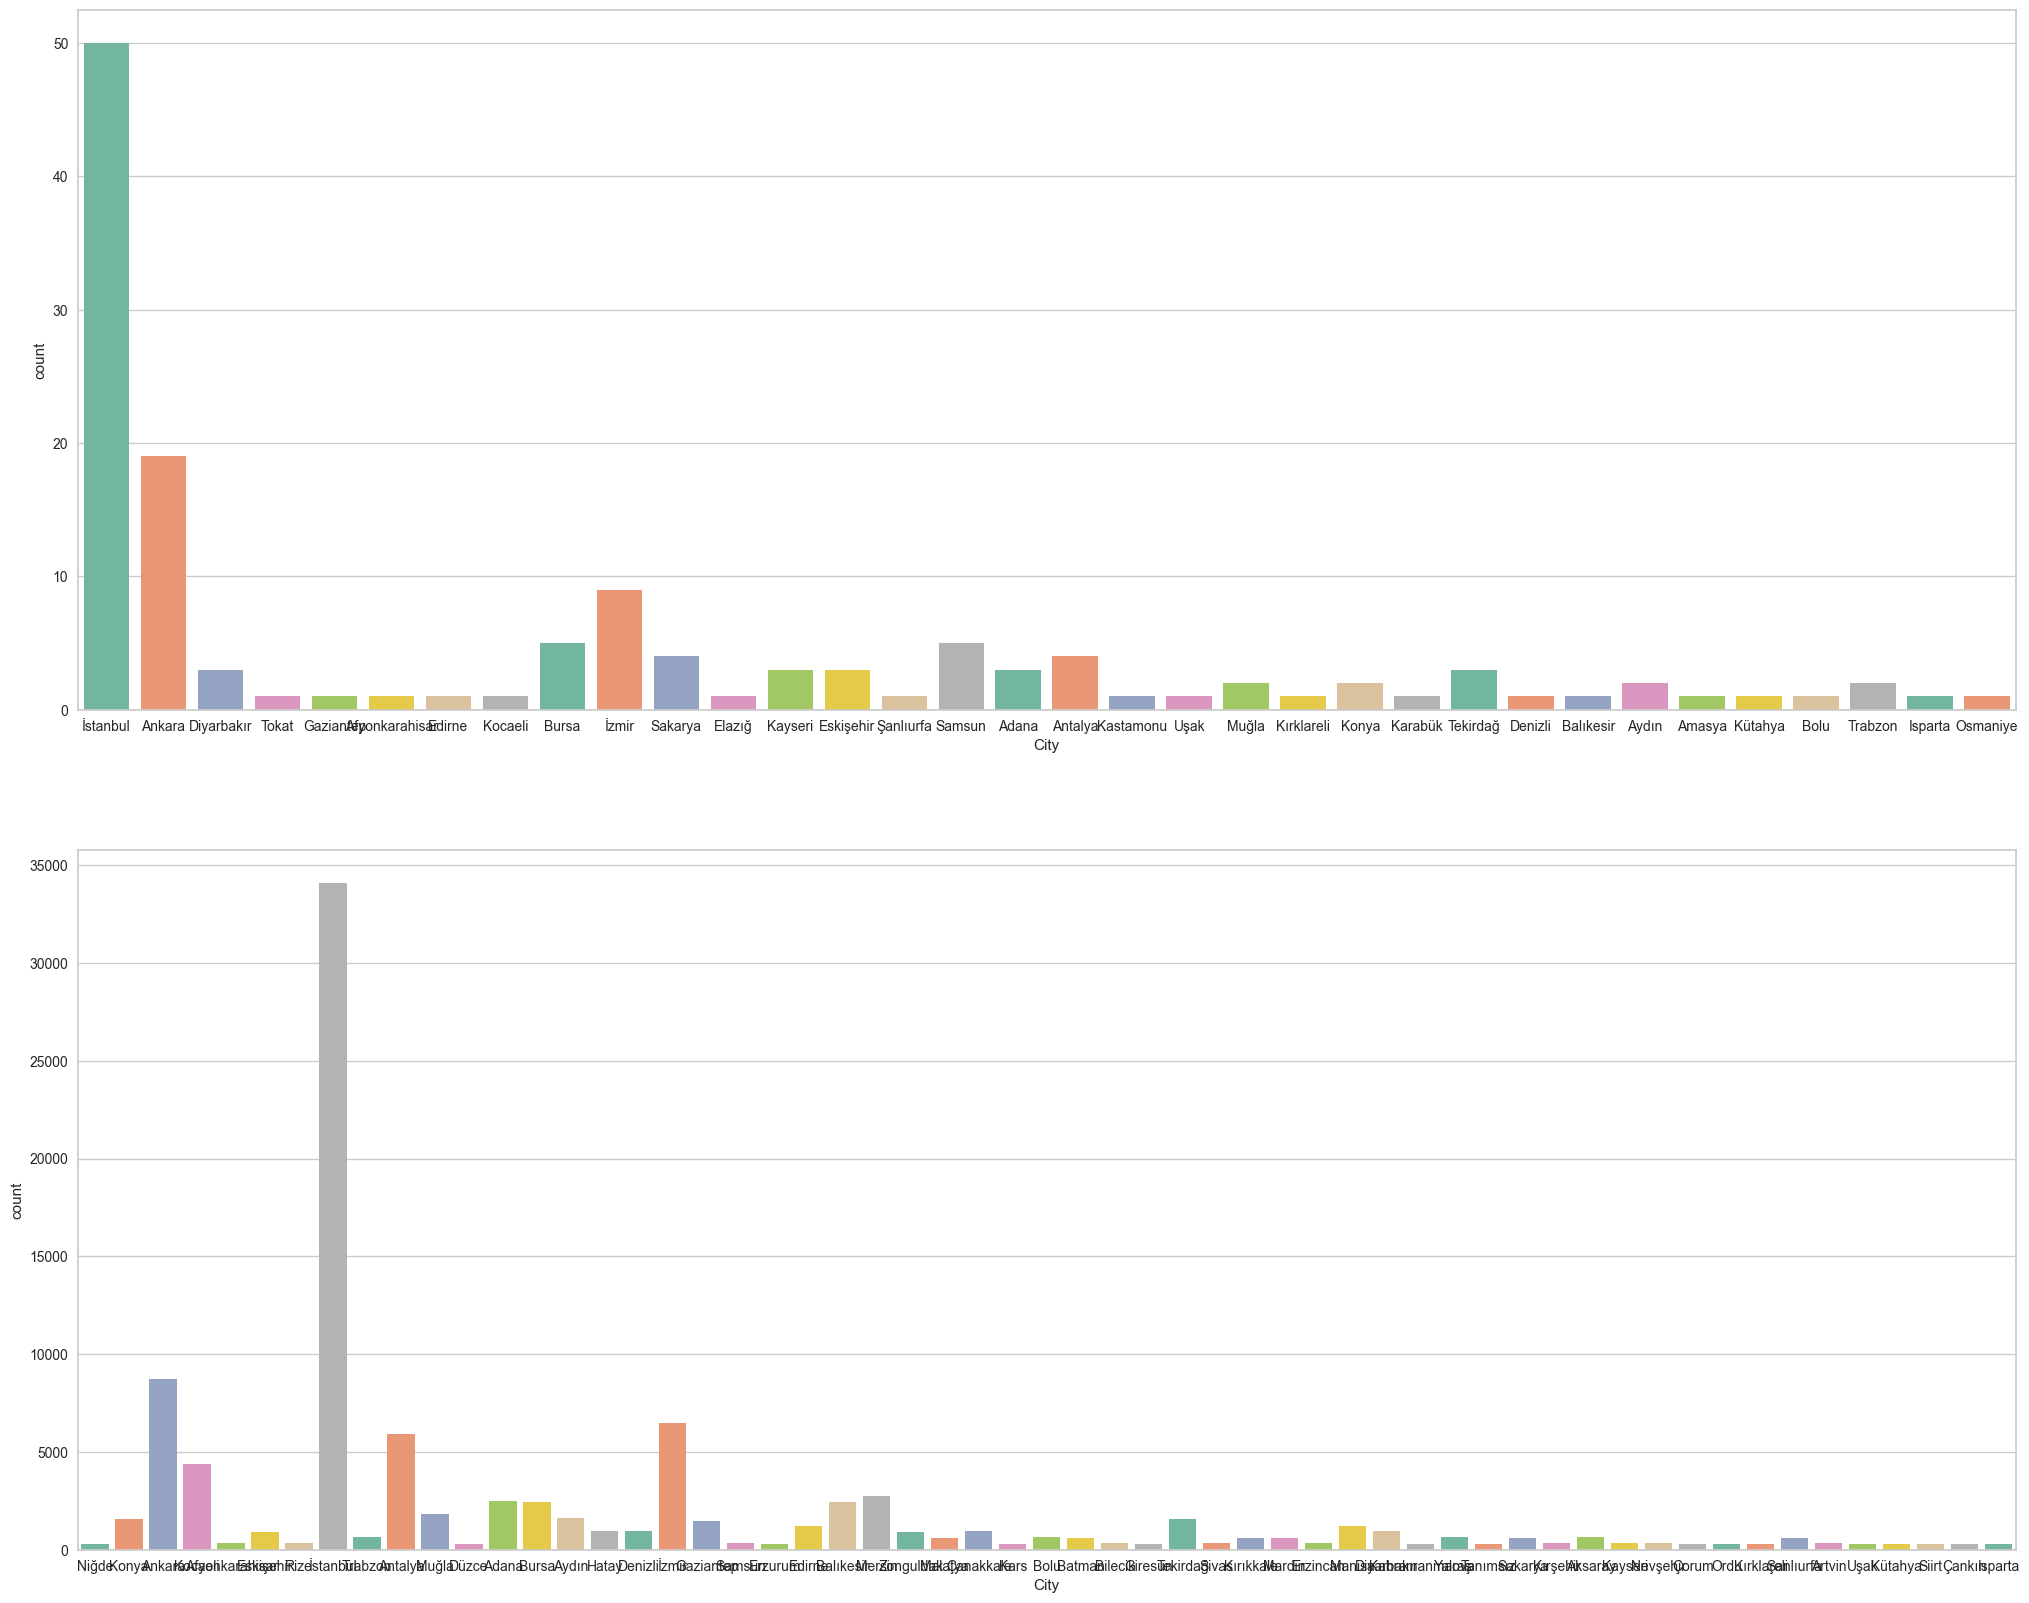

In [59]:
plt.subplots(2,1,figsize=(25,20))

plt.subplot(2,1,1)
sns.countplot(x=data_train.City, data=data_train, palette="Set2")

plt.subplot(2,1,2)
sns.countplot(x=data_test.City, data=data_test, palette="Set2")

plt.show()

In [61]:
counts = data_train['City'].value_counts()
percent = ((data_train['City'].value_counts()/data_train['City'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count_train':counts,'percentage':percent}).head(5)

,count_train,percentage
City,,
İstanbul,50,36.5%
Ankara,19,13.9%
İzmir,9,6.6%
Bursa,5,3.6%
Samsun,5,3.6%


In [62]:
counts = data_test['City'].value_counts()
percent = ((data_test['City'].value_counts()/data_test['City'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count_test':counts,'percentage':percent}).head(5)

,count_test,percentage
İstanbul,34087,34.1%
Ankara,8720,8.7%
İzmir,6465,6.5%
Antalya,5911,5.9%
Kocaeli,4364,4.4%


Dans le train pres de 60% des restaurants sont ouverts dans les villes comme Istanbul,Ankara, Izmir. Ce qui justfie l'allure de notre graphe sur les villes

Pour le test egalement, Istanbul reste la ville avec le plus de restaurants ouverts suivie, comme dans le train, d'Ankara et d' Izmir. 

- La Variable City Group: cette variable donne la type de villes[Grande ville, autres] dans laquelle un restaurant se trouve

In [23]:
data_train['City Group'].describe()

count            137
unique             2
top       Big Cities
freq              78
Name: City Group, dtype: object

In [24]:
data_train['City Group'].unique()

array(['Big Cities', 'Other'], dtype=object)

In [63]:
data_test['City Group'].describe()

count     100000
unique         2
top        Other
freq       50728
Name: City Group, dtype: object

In [64]:
data_test['City Group'].unique()

array(['Other', 'Big Cities'], dtype=object)

<Axes: xlabel='City Group', ylabel='count'>

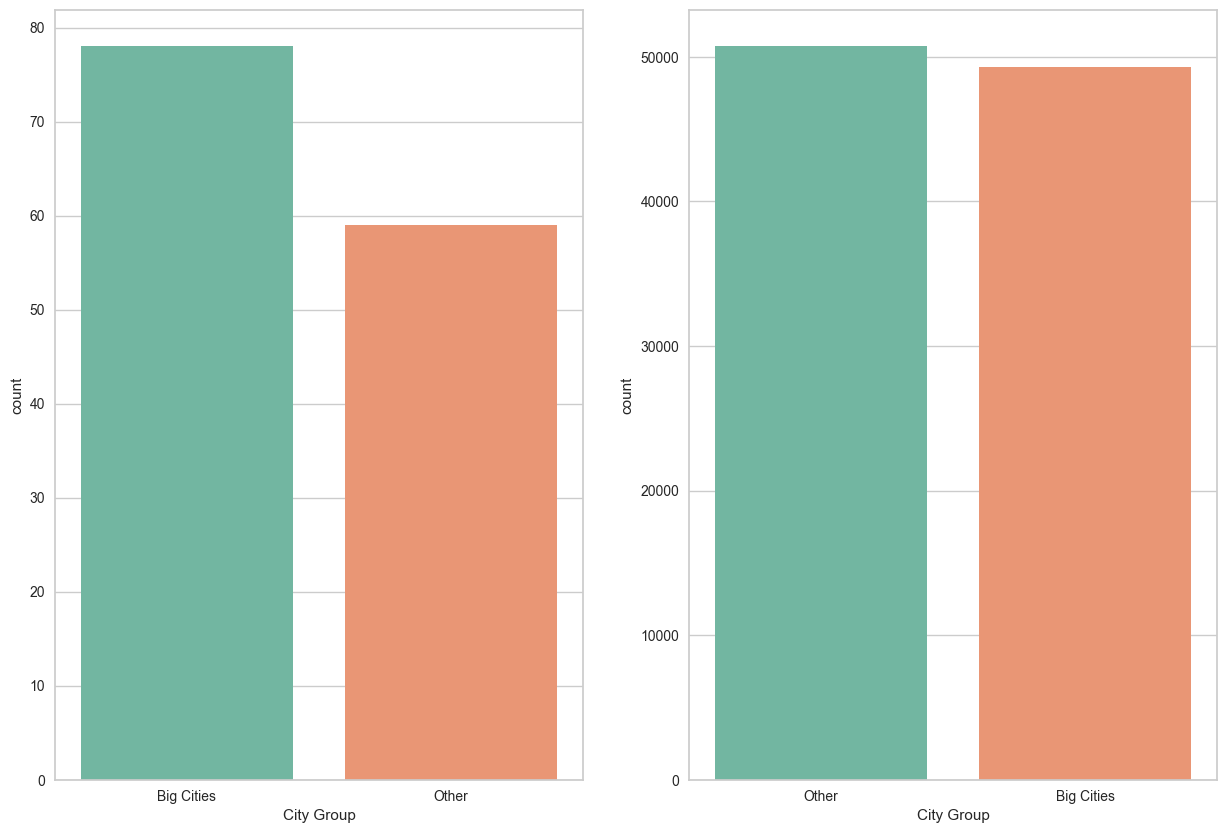

In [68]:
figure, axes = plt.subplots(1,2, figsize=(15,10))

plt.subplot(1,2,1)
sns.countplot(x=data_train['City Group'], data=data_train, palette="Set2")

plt.subplot(1,2,2)
sns.countplot(x=data_test['City Group'], data=data_test, palette="Set2")

Ce  graphe nous montre que la majeur partie des restaurants ouverts du `train` se trouve dans des "Big cities".
Alors que pour le `test`, la plus grande partie se trouve dans "Other", pour designer les autres villes 

### Etude de la distribution des feature en fonction de la variable revenue

- Type et revenue

<Axes: xlabel='Type', ylabel='revenue'>

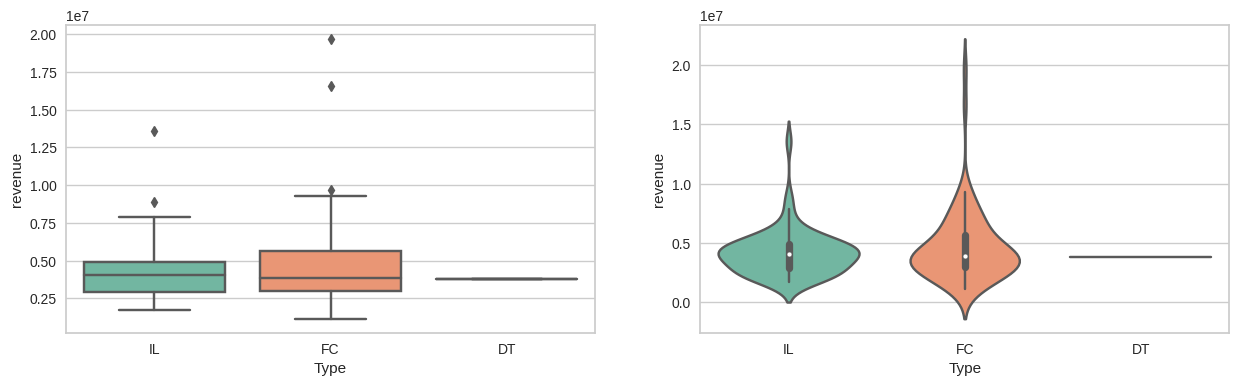

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.boxplot(x=data_train.Type, y=data_train.revenue, data=data_train, palette="Set2", ax=axes[0])
sns.violinplot(x=data_train.Type, y=data_train.revenue, data=data_train, palette="Set2", ax=axes[1])


Les restaurants "FC" (FoodCourt) et "IL" (Inline) sont les types de restaurants préférés, dont la distribution est similaire et qui génèrent également de bons revenus.

- City group et revenue

<Axes: xlabel='City Group', ylabel='revenue'>

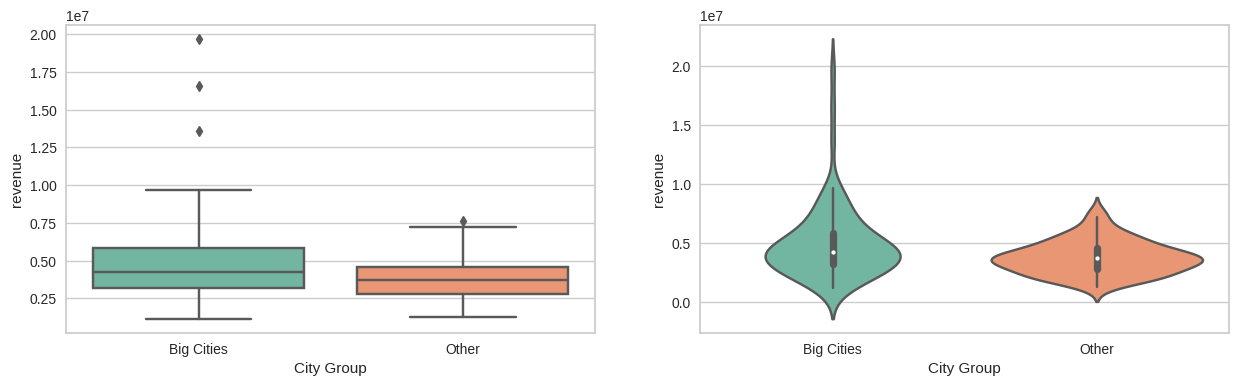

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.boxplot(x=data_train['City Group'], y=data_train.revenue, data=data_train, palette="Set2", ax=axes[0])
sns.violinplot(x=data_train['City Group'], y=data_train.revenue, data=data_train, palette="Set2", ax=axes[1])

Nous pouvons observer que quelques restaurants dans les "grandes villes" réalisent une marge de revenus plus élevée. Il est donc préférable d'ouvrir un nouveau restaurant dans les "grandes villes" pour obtenir des revenus élevés.

- City et revenue

Text(0, 0.5, 'City')

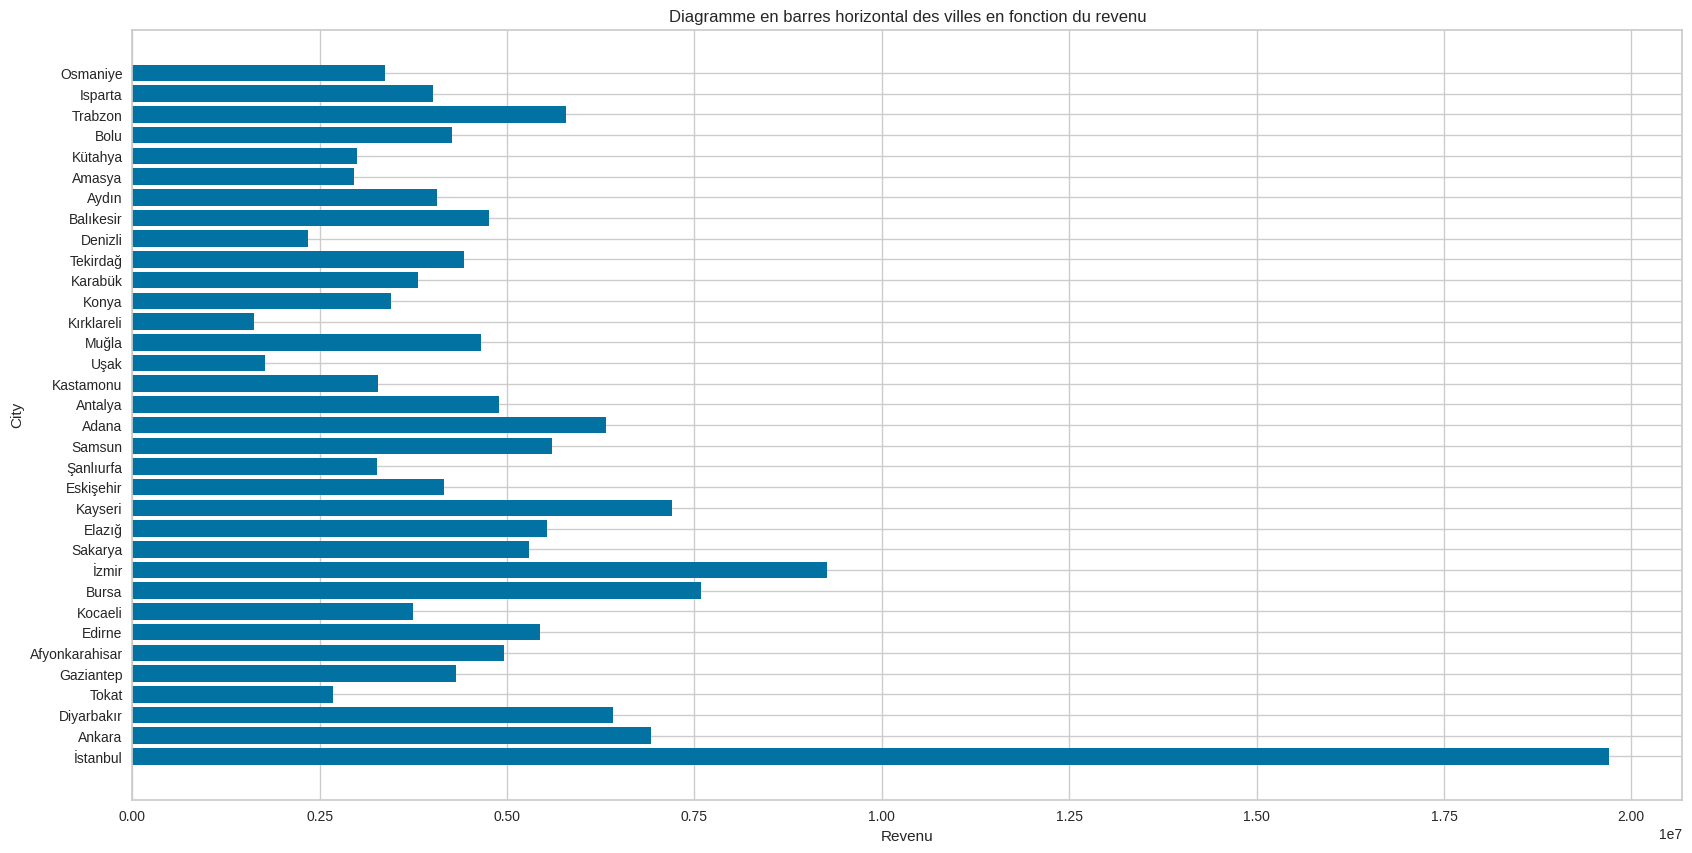

In [71]:
plt.figure(figsize=(20, 10))
plt.barh(data_train.City,data_train.revenue)
plt.title('Diagramme en barres horizontal des villes en fonction du revenu')
plt.xlabel('Revenu')
plt.ylabel('City')

Le restaurant en Istanbul est celui avec plus de revenue qui s'explique en partie par le fait qu'il est le plus represente au niveau du dataset

- Les variables demograpiques P1-P37:
Ce sont des donnees qui representent trois categories. 

Les données démographiques - comprennent la population d'une zone donnée, la répartition par âge et par sexe, les échelles de développement.

Les données immobilières - liées aux m2 de l'emplacement, à la façade de l'emplacement, à la disponibilité des parkings. 

Les données commerciales - y compris l'existence de points d'intérêt tels que les écoles, les banques, les autres opérateurs QSR.

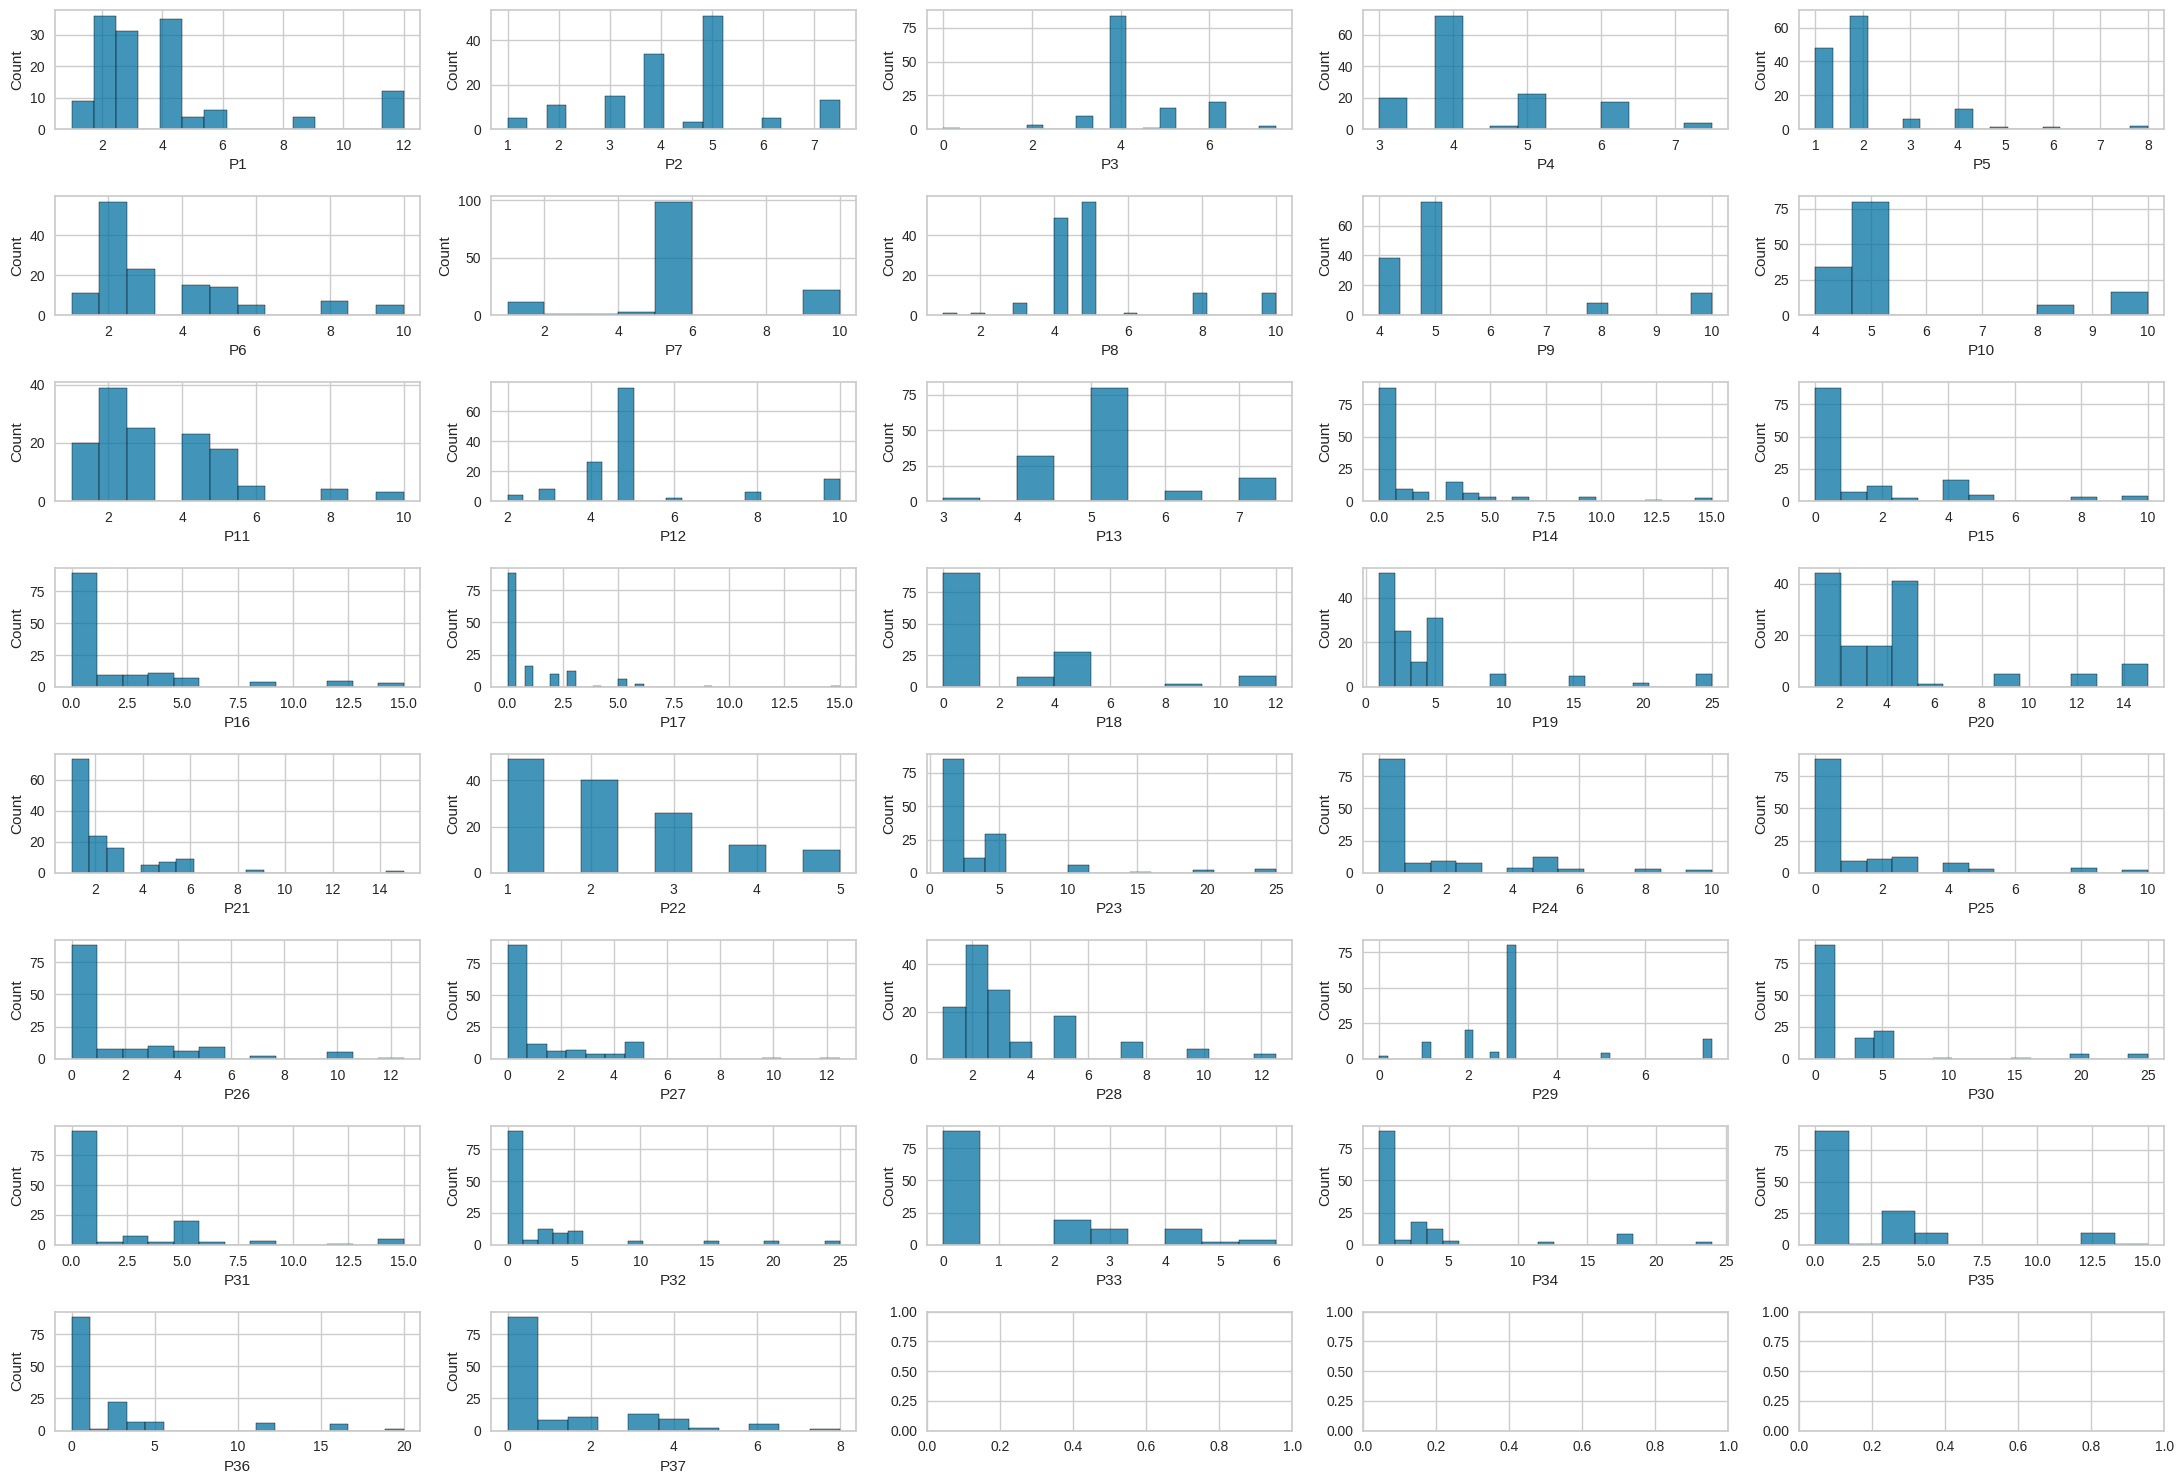

In [29]:
fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(22, 15))
axes = axes.ravel()

# Parcourir les colonnes P1 à P37 et créer un histogramme pour chaque
for i in range(1, 38):
    ax = axes[i - 1]
    sns.histplot(data_train['P{}'.format(i)], kde=False, ax=ax)
    ax.set_xlabel('P{}'.format(i))

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()



### Feature Engineering

Dans cette partie, nous allons effectuer les transformations sur les donnees et identifier les key insights pour nos models

- Transformation de la variable 'OpenDate' en Year, Month et YearsOld qui seront de nouvelles colonnes

In [73]:
def newFeatures(df):
  df['Date'] = pd.to_datetime(df['Open Date'],format="%m/%d/%Y")
  df['Year'] = df['Date'].dt.year
  df['Month'] = df['Date'].dt.month
  df['Years Old'] = pd.to_datetime('23-03-2015').year - df['Date'].dt.year
  df = df.drop(['Open Date','Date'],axis=1)
  return df

In [74]:
data_train = newFeatures(data_train)
data_test = newFeatures(data_test)

/var/folders/f4/y_j60wgd5pxds0210hxtkc9w0000gn/T/ipykernel_53869/1154867233.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Years Old'] = pd.to_datetime('23-03-2015').year - df['Date'].dt.year
/var/folders/f4/y_j60wgd5pxds0210hxtkc9w0000gn/T/ipykernel_53869/1154867233.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Years Old'] = pd.to_datetime('23-03-2015').year - df['Date'].dt.year


In [76]:
data_train.head()

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Year,Month,Years Old
0,0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,1999,7,16
1,1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,2008,2,7
2,2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,2013,3,2
3,3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,2012,2,3
4,4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,2009,5,6


In [77]:
data_test.head()

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,Year,Month,Years Old
0,0,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,5,4,5,5,5,3,4.0,0,0,0,2,0,5,5,3,1,4,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2011,1,4
1,1,Konya,Other,IL,3,4.0,4.0,4.0,2,2,5,3,4,4,2,4,5.0,0,0,0,0,0,5,5,3,2,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2011,3,4
2,2,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,2,5,4,4,5,4,5,5.0,0,0,0,0,0,5,5,5,5,5,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2013,10,2
3,3,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,3,5,4,5,4,3,4,5.0,0,0,0,0,4,4,4,3,2,2,0,0,0.0,0.0,2.0,3.0,0,4,0,0,0,0,0,0,2013,5,2
4,4,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,2,5,4,5,4,3,5,4.0,0,0,0,0,0,1,5,3,1,1,0,0,0.0,0.0,5.0,3.0,0,0,0,0,0,0,0,0,2013,7,2


Nous voyons que les colonnes Year, Month, YearsOLd sont ajoutees dans le dataset alors que la colonne OpenDate est supprimee

- Suppression de la colonne ID

In [78]:
data_train.drop(["Id"], axis=1, inplace=True)
data_test.drop(["Id"], axis=1, inplace=True)

In [79]:
data_train.head()

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Year,Month,Years Old
0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,1999,7,16
1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,2008,2,7
2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,2013,3,2
3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,2012,2,3
4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,2009,5,6


In [80]:
data_test.head()

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,Year,Month,Years Old
0,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,5,4,5,5,5,3,4.0,0,0,0,2,0,5,5,3,1,4,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2011,1,4
1,Konya,Other,IL,3,4.0,4.0,4.0,2,2,5,3,4,4,2,4,5.0,0,0,0,0,0,5,5,3,2,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2011,3,4
2,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,2,5,4,4,5,4,5,5.0,0,0,0,0,0,5,5,5,5,5,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2013,10,2
3,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,3,5,4,5,4,3,4,5.0,0,0,0,0,4,4,4,3,2,2,0,0,0.0,0.0,2.0,3.0,0,4,0,0,0,0,0,0,2013,5,2
4,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,2,5,4,5,4,3,5,4.0,0,0,0,0,0,1,5,3,1,1,0,0,0.0,0.0,5.0,3.0,0,0,0,0,0,0,0,0,2013,7,2


- Distribution des nouvelles variables creees par rapport au revenue
    - Month

<Axes: xlabel='Month', ylabel='revenue'>

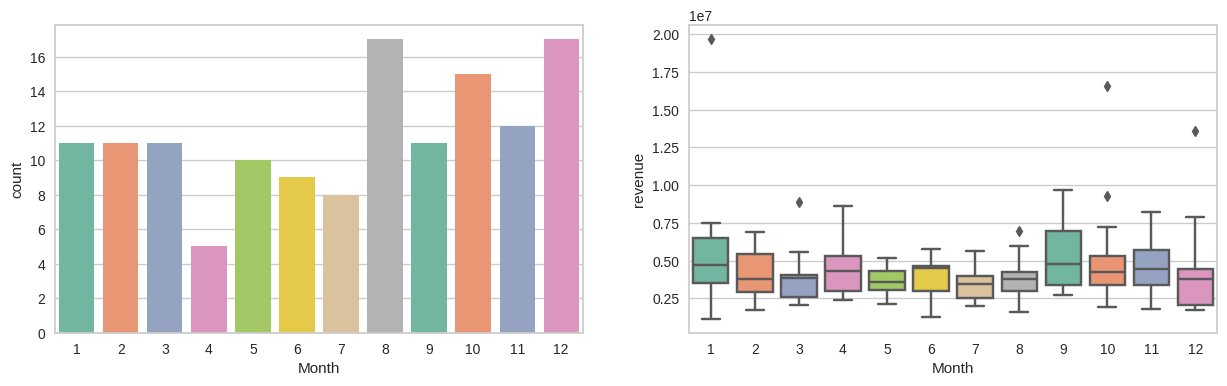

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.countplot(x=data_train.Month, data_train=data_train, palette="Set2", ax=axes[0])
sns.boxplot(x=data_train.Month, y=data_train.revenue, data_train=data_train, palette="Set2", ax=axes[1])

La plupart des nouveaux restaurants ouvrent leurs portes en août et en décembre.
Les restaurants enregistrent de bons revenus en avril, en septembre et en janvier.

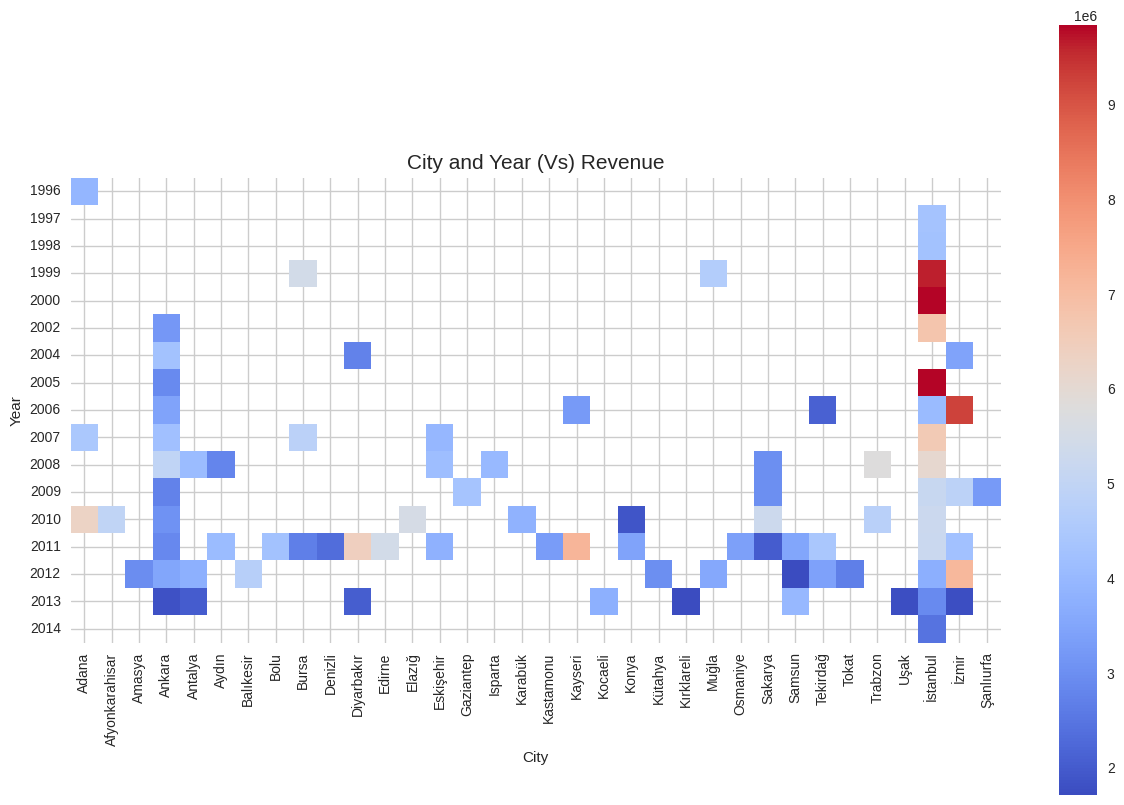

In [36]:
df = pd.DataFrame({'City':data_train['City'],'Year':data_train['Year'],'revenue':data_train['revenue']})

df_wide=df.pivot_table( index='Year', columns='City', values='revenue' )

fig, ax = plt.subplots(figsize=(15,10))         #linecolors can be 'r', 'g', 'b', 'k', 'y', 'm', 'c'
plot = sns.heatmap(df_wide, annot=False,linewidths=.001,linecolor='g',ax=ax,cmap='coolwarm',robust=True, square=True) #annot=True writes data_train in rect boxes
plt.title('City and Year (Vs) Revenue',size=15)
plt.show()

Le graphique ci-dessus montre que, parmi les autres villes, Istanbul est celle qui génère les revenus les plus élevés et que la plupart d'entre elles préfèrent ouvrir de nouveaux restaurants presque chaque année depuis 1997. Ankara et Izmir sont les villes qui génèrent de bons revenus et, après Istanbul, ce sont les villes les plus propices à l'ouverture d'un nouveau restaurant chaque année.

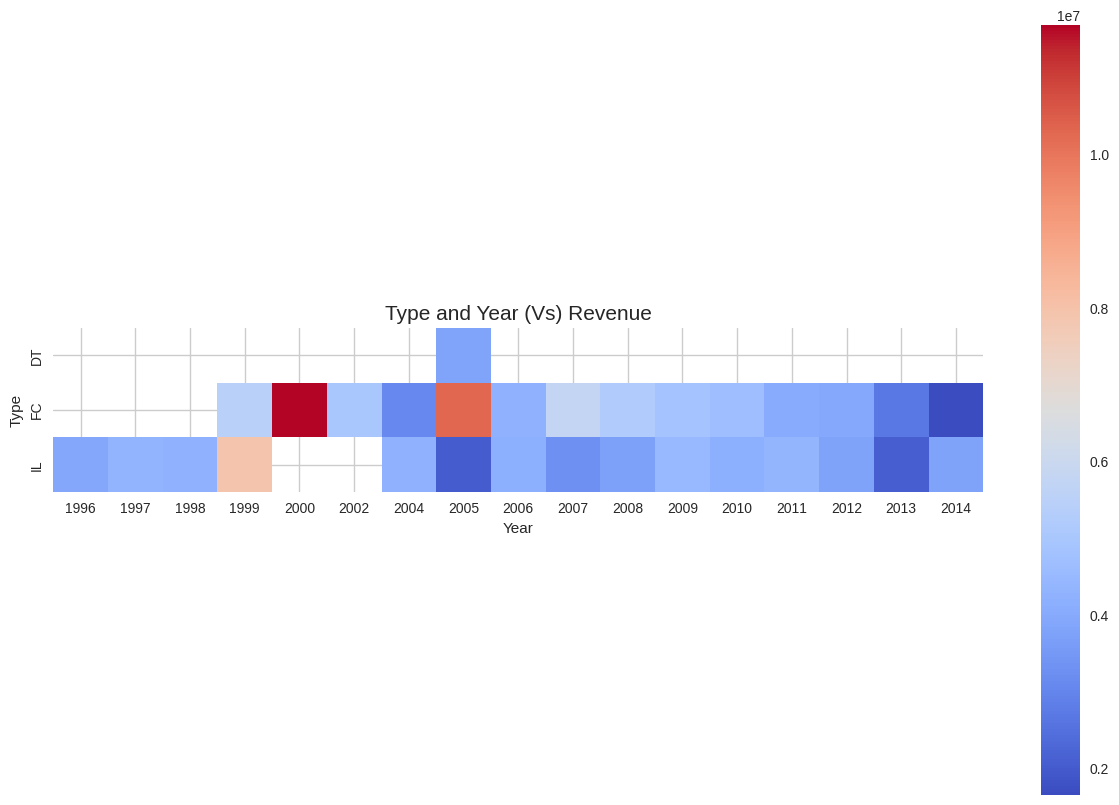

In [37]:
df = pd.DataFrame({'Type':data_train['Type'],'Year':data_train['Year'],'revenue':data_train['revenue']})

df_wide=df.pivot_table( index='Type', columns='Year', values='revenue' )

fig, ax = plt.subplots(figsize=(15,10))         #linecolors can be 'r', 'g', 'b', 'k', 'y', 'm', 'c'
plot = sns.heatmap(df_wide, annot=False,linewidths=.001,linecolor='g',ax=ax,cmap='coolwarm',robust=True, square=True) #annot=True writes data_train in rect boxes
plt.title('Type and Year (Vs) Revenue',size=15)
plt.show()

Presque chaque année, la plupart des nouveaux restaurants préfèrent le type "FC" (Food Court) ou "IL" (Inline). Le revenu moyen de ces deux types de restaurants est presque similaire.

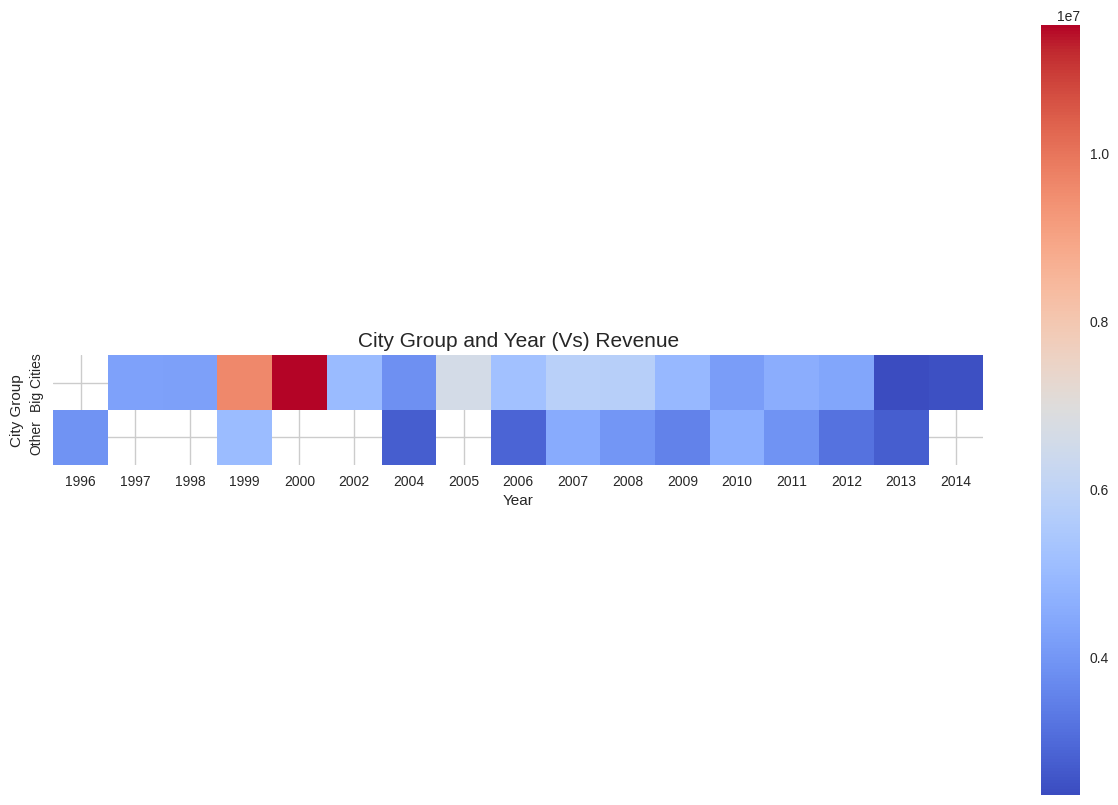

In [38]:
df = pd.DataFrame({'City Group':data_train['City Group'],'Year':data_train['Year'],'revenue':data_train['revenue']})

df_wide=df.pivot_table( index='City Group', columns='Year', values='revenue' )

fig, ax = plt.subplots(figsize=(15,10))         #linecolors can be 'r', 'g', 'b', 'k', 'y', 'm', 'c'
plot = sns.heatmap(df_wide, annot=False,linewidths=.001,linecolor='g',ax=ax,cmap='coolwarm',robust=True, square=True) #annot=True writes data_train in rect boxes
plt.title('City Group and Year (Vs) Revenue',size=15)
plt.show()

Nous pouvons observer que depuis 1997, quelques restaurants ouvrent chaque année dans les "grandes villes" et que les recettes ont été bonnes entre 1997 et 2012.

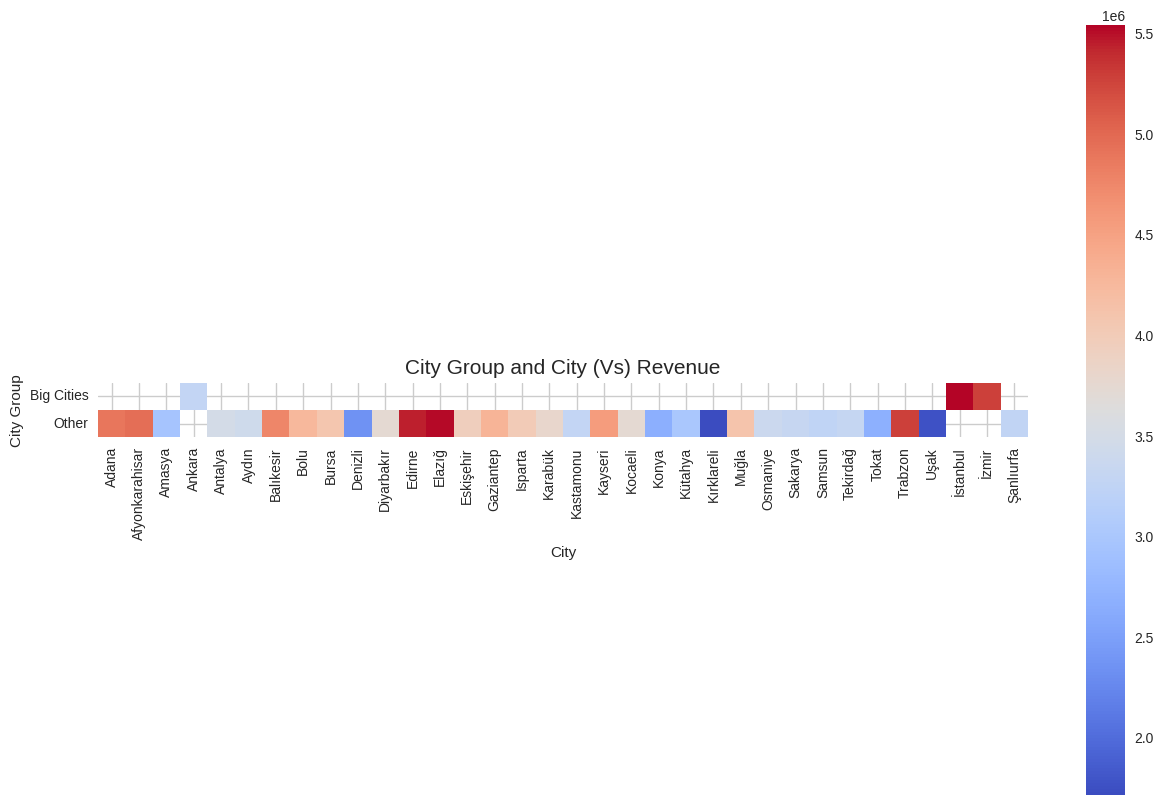

In [39]:
df = pd.DataFrame({'City Group':data_train['City Group'],'City':data_train['City'],'revenue':data_train['revenue']})

df_wide=df.pivot_table( index='City Group', columns='City', values='revenue' )

fig, ax = plt.subplots(figsize=(15,10))         #linecolors can be 'r', 'g', 'b', 'k', 'y', 'm', 'c'
plot = sns.heatmap(df_wide, annot=False,linewidths=.001,linecolor='g',ax=ax,cmap='coolwarm',robust=True, square=True) #annot=True writes data_train in rect boxes
plt.title('City Group and City (Vs) Revenue',size=15)
plt.show()

La principale information de ce graphique est qu'Ankara, Istanbul et Izmir sont les seules grandes villes.
Parmi les autres villes, Edime, Elazig et Trabzon fournissent des revenus plus élevés.

Text(0.5, 1.0, 'Type and City (Vs) Revenue')

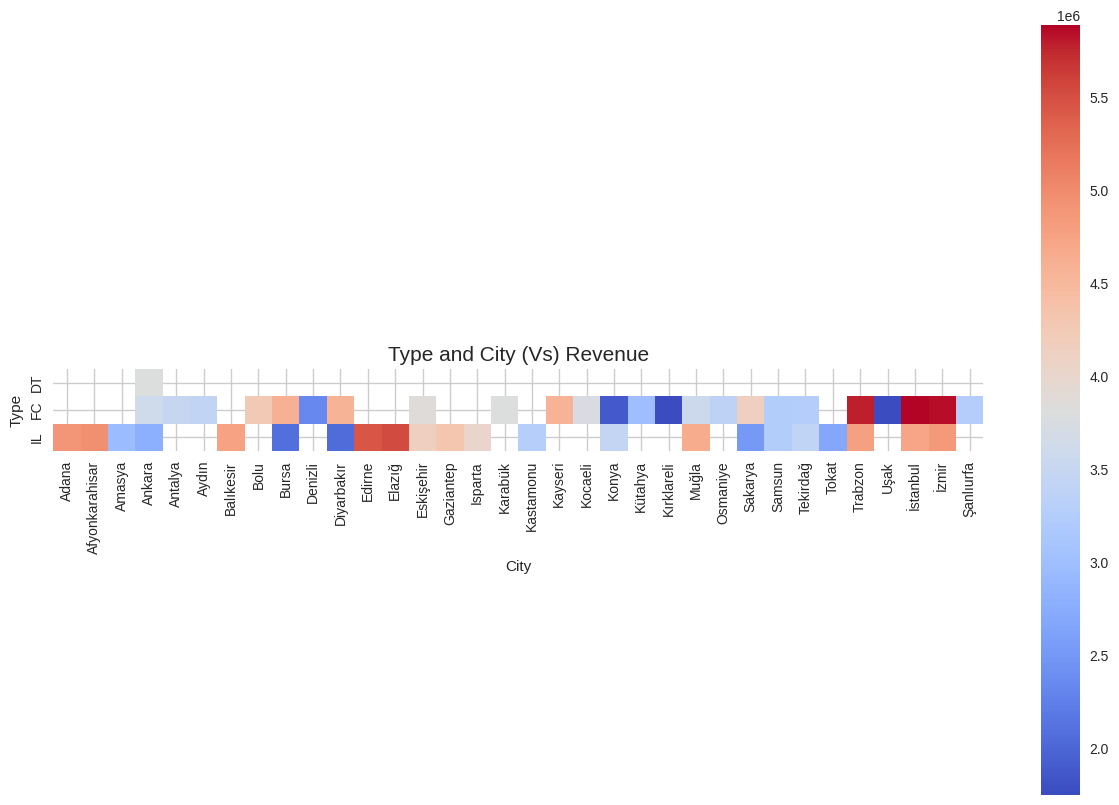

In [40]:
df = pd.DataFrame({'Type':data_train['Type'],'City':data_train['City'],'revenue':data_train['revenue']})

df_wide=df.pivot_table( index='Type', columns='City', values='revenue' )

fig, ax = plt.subplots(figsize=(15,10))         #linecolors can be 'r', 'g', 'b', 'k', 'y', 'm', 'c'
plot = sns.heatmap(df_wide, annot=False,linewidths=.001,linecolor='g',ax=ax,cmap='coolwarm',robust=True, square=True) #annot=True writes data_train in rect boxes
plt.title('Type and City (Vs) Revenue',size=15)

Dans les "grandes villes" comme Istanbul, Izmir et Ankara, la préférence peut être donnée aux restaurants de type "FC" (Food Court) afin de maximiser les revenus.

In [86]:
X_train = data_train.drop(['revenue'],axis=1)
X_train.head

<bound method NDFrame.head of            City  City Group Type  P1   P2   P3   P4  P5  P6  P7  P8  P9  P10  \
0      İstanbul  Big Cities   IL   4  5.0  4.0  4.0   2   2   5   4   5    5   
1        Ankara  Big Cities   FC   4  5.0  4.0  4.0   1   2   5   5   5    5   
2    Diyarbakır       Other   IL   2  4.0  2.0  5.0   2   3   5   5   5    5   
3         Tokat       Other   IL   6  4.5  6.0  6.0   4   4  10   8  10   10   
4     Gaziantep       Other   IL   3  4.0  3.0  4.0   2   2   5   5   5    5   
..          ...         ...  ...  ..  ...  ...  ...  ..  ..  ..  ..  ..  ...   
132     Trabzon       Other   FC   2  3.0  3.0  5.0   4   2   4   4   4    4   
133       İzmir  Big Cities   FC   4  5.0  4.0  4.0   2   3   5   4   4    5   
134     Kayseri       Other   FC   3  4.0  4.0  4.0   2   3   5   5   5    5   
135    İstanbul  Big Cities   FC   4  5.0  4.0  5.0   2   2   5   5   5    5   
136    İstanbul  Big Cities   FC   4  5.0  3.0  5.0   2   2   5   4   4    5   

     P11 

In [100]:
X_test = data_test

Changer l'rdre des colonnes pour mettre la variable cible sur la derniere colonne

In [96]:
data_train.columns

Index(['City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7',
       'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17',
       'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27',
       'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37',
       'revenue', 'Year', 'Month', 'Years Old'],
      dtype='object')

In [97]:
variables = ['City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7',
       'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17',
       'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27',
       'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37','Year', 'Month', 'Years Old', 'revenue']

data_train = data_train[variables]

In [98]:
data_train.head()

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,Year,Month,Years Old,revenue
0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,1999,7,16,5653753.0
1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,2008,2,7,6923131.0
2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2013,3,2,2055379.0
3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2012,2,3,2675511.0
4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,2009,5,6,4316715.0


In [81]:
Path(REPORT_DIR).mkdir(parents=True, exist_ok=True)

profile = ProfileReport(data_train, title="Restaurant revenue- profiling")
# profile.to_notebook_iframe()
profile.to_file(Path(REPORT_DIR, 'profiling_report.html'))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Selection des features pour l'entrainement

#### Matrice de correlation

In [ ]:
!pip3 install phik

interval columns not set, guessing: ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'Year', 'Month', 'Years Old', 'revenue']


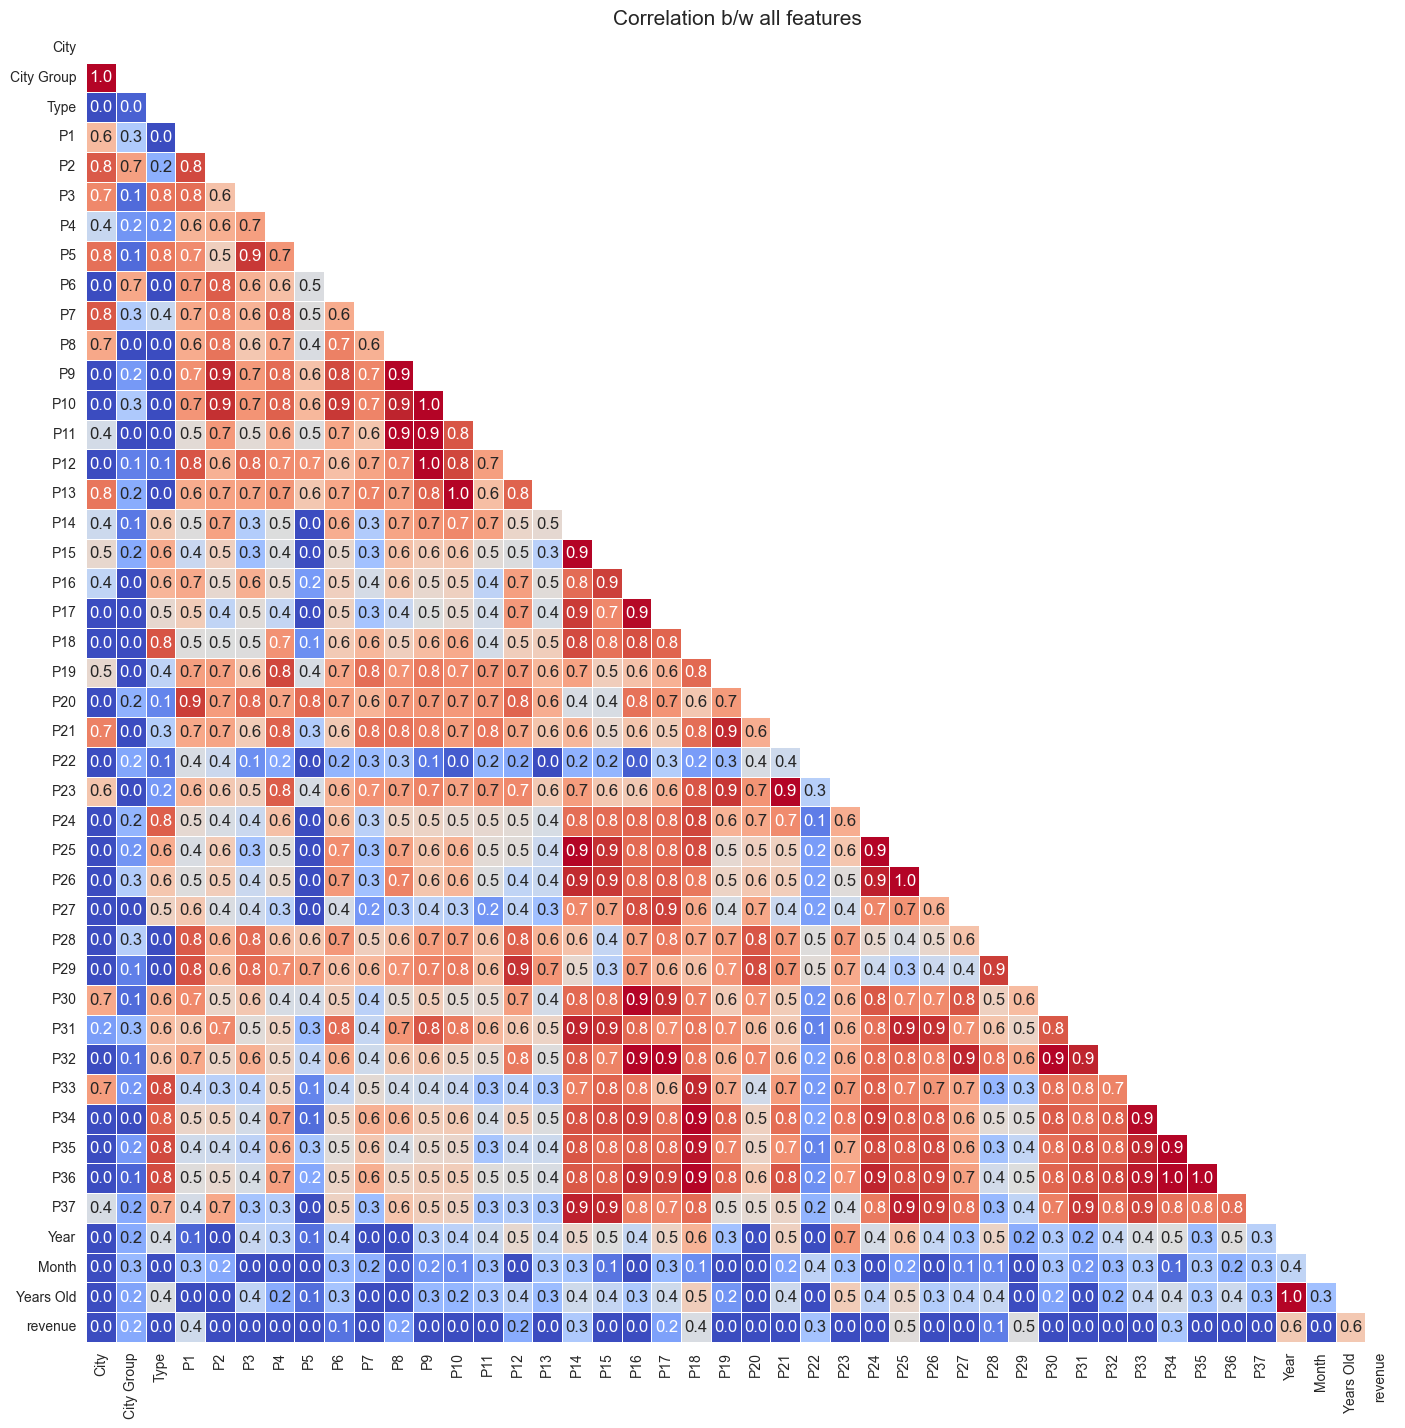

In [99]:
import phik
#Phi_corr = train.drop(['Id','Open Date'],axis=1).phik_matrix()
Phi_corr = data_train.phik_matrix()

mask = np.zeros_like(Phi_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  fig, ax = plt.subplots(figsize=(20,17))         # Sample figsize in inches
  plot = sns.heatmap(Phi_corr, mask=mask, annot=True, fmt='.1f',linewidths=.5, ax=ax,cmap='coolwarm',robust=True, square=True,cbar=False) #annot=True writes data in rect boxes
  plt.title('Correlation b/w all features ',size = 15)
  plt.show()

La matrice de corrélation ci-dessus montre clairement que la plupart des caractéristiques numériques ont une corrélation faible ou nulle avec la variable "revenus". 
La plupart des caractéristiques numériques entre P1 et P37 sont fortement corrélées entre elles. Cela signifie qu'un petit changement dans une caractéristique a un impact sur les changements dans une autre caractéristique.

#### Variables quantitatives/numeriques 

Dans cette partie, nous allons supprimer les variables quantitatives qui sont correlees avec la variable cible et qui ont de fortes correlations avec d'autres variables quantitatives

In [95]:
num_fea = data_train.drop(['City Group','Type'],axis=1)
corr = data_train.corr()

/var/folders/f4/y_j60wgd5pxds0210hxtkc9w0000gn/T/ipykernel_53869/4138300412.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_train.corr()


In [92]:
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))  
corr_col = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

Phi_corrFea = (Phi_corr['revenue'].sort_values(ascending=False)==0) 
no_cor = [col for col in X_train.columns if Phi_corrFea[col]==True]

drop_num = [col for col in corr_col if col not in no_cor]  
drop_num

['P12', 'P17', 'P18', 'P25', 'P28', 'P34']

Ainsi les variable P12, P17, P18, P25, P28 et P34 sont les variables quantitatives fortement correlees d'autres et aussi correlees avec la variable cible

In [101]:

X_train = X_train.drop(drop_num,axis=1)
X_test = X_test.drop(drop_num,axis=1)
X_train.head(1)

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P13,P14,P15,P16,P19,P20,P21,P22,P23,P24,P26,P27,P29,P30,P31,P32,P33,P35,P36,P37,Year,Month,Years Old
0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5.0,1,2,2,5,4,1,3,3,1,1.0,4.0,3.0,5,3,4,5,4,3,4,1999,7,16


### Variables quanlitatives

Vu que les variables P1-P37 sont des variables qui comportent des donnees: demographiques, immobilieres et comerciales et que la variable "City" comporte des modalites differentes entre le train et le test, nous avons decide de supprimer "City" des deux datasets 

In [102]:
X_train = X_train.drop(['City'],axis=1)
X_test = X_test.drop(['City'],axis=1)
X_train.head(10)

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P13,P14,P15,P16,P19,P20,P21,P22,P23,P24,P26,P27,P29,P30,P31,P32,P33,P35,P36,P37,Year,Month,Years Old
0,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5.0,1,2,2,5,4,1,3,3,1,1.0,4.0,3.0,5,3,4,5,4,3,4,1999,7,16
1,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5.0,0,0,0,3,2,1,3,2,0,0.0,0.0,3.0,0,0,0,0,0,0,0,2008,2,7
2,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5.0,0,0,0,1,1,1,1,1,0,0.0,0.0,3.0,0,0,0,0,0,0,0,2013,3,2
3,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,7.5,6,4,9,20,12,6,1,10,2,2.5,2.5,7.5,25,12,10,6,12,12,6,2012,2,3
4,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5.0,2,1,2,2,2,1,2,1,2,3.0,5.0,3.0,5,1,3,2,4,3,3,2009,5,6
5,Big Cities,FC,6,6.0,4.5,7.5,8,10,10,8,8,8,10,6.0,0,0,0,5,6,3,1,5,0,0.0,0.0,5.0,0,0,0,0,0,0,0,2010,2,5
6,Big Cities,IL,2,3.0,4.0,4.0,1,5,5,5,5,5,2,5.0,3,4,4,2,4,1,2,1,5,4.0,5.0,3.0,4,5,2,2,5,4,4,2010,10,5
7,Big Cities,IL,4,5.0,4.0,5.0,2,3,5,4,4,4,4,4.0,0,0,0,3,5,2,4,2,0,0.0,0.0,2.0,0,0,0,0,0,0,0,2011,6,4
8,Other,IL,1,1.0,4.0,4.0,1,2,1,5,5,5,1,5.0,1,1,2,1,1,1,1,1,4,4.0,2.0,3.0,4,5,5,3,5,4,5,2010,8,5
9,Other,IL,6,4.5,6.0,7.5,6,4,10,10,10,10,2,7.5,0,0,0,25,3,3,1,10,0,0.0,0.0,2.5,0,0,0,0,0,0,0,2011,11,4


Encodage des variables categortielles 

In [106]:
def catFea(df):
  labelEncoding = LabelEncoder()
  df['City Group'] = labelEncoding.fit_transform(df['City Group'].astype('str'))
  df['Type'] = labelEncoding.fit_transform(df['Type'].astype('str'))
  return df

X_train = catFea(X_train)
X_test = catFea(X_test)
X_train.head(10)

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P13,P14,P15,P16,P19,P20,P21,P22,P23,P24,P26,P27,P29,P30,P31,P32,P33,P35,P36,P37,Year,Month,Years Old
0,0,2,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5.0,1,2,2,5,4,1,3,3,1,1.0,4.0,3.0,5,3,4,5,4,3,4,1999,7,16
1,0,1,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5.0,0,0,0,3,2,1,3,2,0,0.0,0.0,3.0,0,0,0,0,0,0,0,2008,2,7
2,1,2,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5.0,0,0,0,1,1,1,1,1,0,0.0,0.0,3.0,0,0,0,0,0,0,0,2013,3,2
3,1,2,6,4.5,6.0,6.0,4,4,10,8,10,10,8,7.5,6,4,9,20,12,6,1,10,2,2.5,2.5,7.5,25,12,10,6,12,12,6,2012,2,3
4,1,2,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5.0,2,1,2,2,2,1,2,1,2,3.0,5.0,3.0,5,1,3,2,4,3,3,2009,5,6
5,0,1,6,6.0,4.5,7.5,8,10,10,8,8,8,10,6.0,0,0,0,5,6,3,1,5,0,0.0,0.0,5.0,0,0,0,0,0,0,0,2010,2,5
6,0,2,2,3.0,4.0,4.0,1,5,5,5,5,5,2,5.0,3,4,4,2,4,1,2,1,5,4.0,5.0,3.0,4,5,2,2,5,4,4,2010,10,5
7,0,2,4,5.0,4.0,5.0,2,3,5,4,4,4,4,4.0,0,0,0,3,5,2,4,2,0,0.0,0.0,2.0,0,0,0,0,0,0,0,2011,6,4
8,1,2,1,1.0,4.0,4.0,1,2,1,5,5,5,1,5.0,1,1,2,1,1,1,1,1,4,4.0,2.0,3.0,4,5,5,3,5,4,5,2010,8,5
9,1,2,6,4.5,6.0,7.5,6,4,10,10,10,10,2,7.5,0,0,0,25,3,3,1,10,0,0.0,0.0,2.5,0,0,0,0,0,0,0,2011,11,4


In [107]:
print(X_train.shape,' ',X_test.shape)

(137, 36)   (100000, 36)


Normalisation des variables

In [108]:
scaler = StandardScaler()
# transform data
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [111]:
from sklearn.decomposition import PCA


pca = PCA(n_components = 5)
X_train_PCA = pca.fit_transform(X_train) 
X_test_PCA = pca.transform(X_test) 
explained_variance = pca.explained_variance_ratio_ 
explained_variance

array([0.54578913, 0.15595576, 0.10573787, 0.04423735, 0.02887449])

In [112]:
pca_train_df = pd.DataFrame(data=X_train_PCA, columns=[f'PC{i+1}' for i in range(5)])
pca_test_df = pd.DataFrame(data=X_test_PCA, columns=[f'PC{i+1}' for i in range(5)])

In [113]:
pca_train_df.head()

,PC1,PC2,PC3,PC4,PC5
0,3.234116,-5.476372,12.558347,0.254966,-1.048717
1,-7.403078,0.221298,1.080545,4.924357,-0.120663
2,-9.110998,-0.664020,-6.153260,3.635112,0.105869
3,34.324080,3.116952,-7.633404,3.643681,-5.690166
4,-0.285865,-6.089023,-1.678060,1.227930,-0.267627


In [114]:
pca_test_df.head()

,PC1,PC2,PC3,PC4,PC5
0,-6.125144,3.291569,-2.707626,5.310981,-4.010023
1,-6.907318,2.048209,-2.719192,3.803367,-1.946686
2,-5.444033,5.123363,-4.570865,-3.392124,-2.271859
3,-6.181161,1.672185,-5.602025,2.113989,-1.289138
4,-8.254285,0.459390,-5.610554,0.026689,-0.524690
